# Project Summary

Ricardo B. Garcia (rbgarcia@gmail.com)

This is a Data Science project aimed at deriving insights from data analysis to solve business problems. This project is inspired in the **`House Rocket Project`**: https://www.comunidadedatascience.com/os-5-projetos-de-data-science-que-fara-o-recrutador-olhar-para-voce/ <br>

<b>Business problem</b> <br>
The KC Real Estate Company is a fictious company located in the King County, Washington, USA. It has a “wholetailing” business model, that is, it buys discounted properties and sells them near their retail value after making cosmetic improvements.

The business problem is to maximize profits by identifying the best opportunities in the market. In specific, the problem is to identify the properties below the market price in which the estimated improvement costs remain within a satisfactory level.

There are thousands of properties for sale with different attributes such as condition, grade, number of bedrooms, and so on. An audit identified several inefficiencies and recommended the KC company to hire a data scientist to improve the processes.

The Data Scientist was requested to: 
- Identify the best months for buying and selling properties
- Identify the most discounted properties and estimate the investment (price + estimated improvement costs) based on objective criteria (see below)
- Produce an online dashboard for the properties with buy recommendation, including a table with the recommended properties, interactive filters according to properties characteristics and a map with their locations.

The business team informed that improvement costs should not exceed 2\% of the property price, and that the average improvement costs vary according to the property condition:<br>

- US\\$ 3.00 per sqft: condition ratings <= 2
- US\\$ 2.00 per sqft: condition ratings 3 or 4
- US\\$ 1.50 per sqft: condition rating 5

<b> Project's assumptions </b>
- The KC Company is focused on properties up to US \$ 800,000.00
- The `kc_house_data.csv` is the portfolio of properties available in the market
- The following columns will not be considered: `view`, `sqft_living15`, `sqft_lot15`



**The dataset:** https://www.kaggle.com/datasets/shivachandel/kc-house-data

|    Attribute    |                         Meaning                         |
| :-------------: | :----------------------------------------------------------: |
|       id        |      Property identification        |
|      date       |                    Listing date                     |
|      price      |    Listing price     |
|    bedrooms     |                      Number of bedrooms                       |
|    bathrooms    | Number of bathrooms*  |
|   sqft_living   | Square footage of the living area |
|    sqft_lot     |     Square footage of the lot     |
|     floors      |                 Number of floors                  |
|   waterfront    | The property is waterfront |
|      view       | Not used in this project|
|    condition    | Property condition (1 to 5) |
|      grade      | Grade quality of the materials, structure and design |
|  sqft_above     | Square footage of living area excluding the basement  |
|  sqft_basement  | Square footage of the basement  |
|    yr_built     |               Year of construction               |
|  yr_renovated   |                Year of renovation                 |
|     zipcode     |                         ZIP code                        |
|       lat       |                           Latitude                           |
|      long       |                          Longitude                           |
| sqft_livining15 | Not used in this project |
|   sqft_lot15    | Not used in this project|

\* A full bathroom has a sink, a shower, a bathtub, and a toilet, and it is counted as "1". Other bathrooms are coded as proportions (e.g., 0.75 for a sink, a shower, and a toilet).

# Project development

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import geopandas as gpd
import contextily as cx

## General settings

In [2]:
# Values up to 2 decimals 0.00
pd.set_option('display.float_format', '{:.2f}'.format )
# plots with seaborn style
plt.style.use('seaborn')

# Data

Here, we load the original dataset.

In [3]:
data = pd.read_csv('kc_house_data.csv')
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])
display(data.head())

Rows: 21613
Columns: 21


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180.00,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170.00,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770.00,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050.00,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680.00,0,1987,0,98074,47.62,-122.05,1800,7503


## Data consistency

Here, we verify the dataset consistency: data types, duplicates, missing values, number of unique values per column, and range of data distribution. 

### Types

In [4]:
dtypes = data.dtypes.reset_index()
dtypes.columns = ['column', 'type']
dtypes['first_row'] = data.head(1).T.reset_index()[0]
display(dtypes)

,column,type,first_row
0,id,int64,7129300520
1,date,object,20141013T000000
2,price,float64,221900.00
3,bedrooms,int64,3
4,bathrooms,float64,1.00
5,sqft_living,int64,1180
6,sqft_lot,int64,5650
7,floors,float64,1.00
8,waterfront,int64,0
9,view,int64,0


<b>Note:</b> The columns with dates should be verified.  

#### Verifying the columns with dates

In [5]:
data[['date', 'yr_built', 'yr_renovated']].head(3)

,date,yr_built,yr_renovated
0,20141013T000000,1955,0
1,20141209T000000,1951,1991
2,20150225T000000,1933,0


<b>Note:</b> The column `date` should be converted to datetime type. Analyses involving `yr_renovated` should exclude rows with 0. 

### Duplicates

In [6]:
n_duplicates = data.shape[0] - data.drop_duplicates(subset='id').shape[0]
print('Number of duplicated data:', n_duplicates)

Number of duplicated data: 177


<b>Note:</b> The duplicates should be excluded.

### Missing

In [7]:
df_missing = data.isna().sum().reset_index()
df_missing.columns = ['column', 'missing values']
display(df_missing)

,column,missing values
0,id,0
1,date,0
2,price,0
3,bedrooms,0
4,bathrooms,0
5,sqft_living,0
6,sqft_lot,0
7,floors,0
8,waterfront,0
9,view,0


#### Verifying missing data

In [8]:
cols = ['sqft_living','sqft_basement', 'sqft_above']
data.loc[data['sqft_above'].isna(), cols]

,sqft_living,sqft_basement,sqft_above
10,3560,1700,NaN
17,1600,0,NaN


<b>Note:</b> Two missing data in `sqft_above` should be treated. See below that `sqft_above` is equal to `sqft_living` - `sqft_basement`.

In [9]:
# Sample showing that sqft_above = sqft_living - sqft_basement
data[['sqft_living','sqft_basement', 'sqft_above']].head(4)

,sqft_living,sqft_basement,sqft_above
0,1180,0,1180.00
1,2570,400,2170.00
2,770,0,770.00
3,1960,910,1050.00


### Unique values

Verifying the number of unique values for each column.

In [10]:
df_unique = data.nunique().reset_index()
df_unique.columns = ['column', 'unique values']
df_unique.sort_values('unique values', inplace=True)
display(df_unique)

,column,unique values
8,waterfront,2
9,view,5
10,condition,5
7,floors,6
11,grade,12
3,bedrooms,13
4,bathrooms,30
16,zipcode,70
15,yr_renovated,70
14,yr_built,116


### Data distributions

In [11]:
to_drop = ['id', 'waterfront', 'view', 'zipcode', 'lat', 'long']
description = data.drop(to_drop, axis=1).describe().loc[['min', '25%', '50%', '75%', 'max']].T
display(description)

,min,25%,50%,75%,max
price,75000.00,321950.00,450000.00,645000.00,7700000.00
bedrooms,0.00,3.00,3.00,4.00,33.00
bathrooms,0.00,1.75,2.25,2.50,8.00
sqft_living,290.00,1427.00,1910.00,2550.00,13540.00
sqft_lot,520.00,5040.00,7618.00,10688.00,1651359.00
floors,1.00,1.00,1.50,2.00,3.50
condition,1.00,3.00,3.00,4.00,5.00
grade,1.00,7.00,7.00,8.00,13.00
sqft_above,290.00,1190.00,1560.00,2210.00,9410.00
sqft_basement,0.00,0.00,0.00,560.00,4820.00


<b>Note:</b> There are some atypical properties, such as with 33 bedrooms or 8 bathrooms.

#### Verifying atypical data

In [12]:
data.loc[data['bedrooms']==33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.00,33,1.75,1620,6000,1.00,0,0,...,7,1040.00,580,1947,0,98103,47.69,-122.33,1330,4700


<b>Note:</b> It will be corrected to 3, as it is not a large property considering the 'sqft_living', 'sqft_lot', and 'floors'.

In [13]:
data.loc[data['bathrooms'] == 8]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,6762700020,20141013T000000,7700000.00,6,8.00,12050,27600,2.50,0,3,...,13,8570.00,3480,1910,1987,98102,47.63,-122.32,3940,8800
12777,1225069038,20140505T000000,2280000.00,7,8.00,13540,307752,3.00,0,4,...,12,9410.00,4130,1999,0,98053,47.67,-121.99,4850,217800


<b>Note:</b> These are correct, the properties are large. 

# Data transformation

Here, we implement data transformation according to the data consistency verification and the project's assumptions.

### Data type adjustment

In [14]:
# Adjusting dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Verifying
display(data[['date']].dtypes)
display(data[['date']].head(3))

date    datetime64[ns]
dtype: object

,date
0,2014-10-13
1,2014-12-09
2,2015-02-25


### Droping duplicates

In [15]:
# Drop duplicates keeping 'last' to keep the last sell event 
data.drop_duplicates(subset='id', keep='last', inplace=True)

### Treatment of missing data

In [16]:
# Verifying the missing data
cols = ['sqft_living','sqft_basement', 'sqft_above']
data.loc[data['sqft_above'].isna(), cols]

,sqft_living,sqft_basement,sqft_above
10,3560,1700,NaN
17,1600,0,NaN


<b>Note:</b> 'sqft_above' is equal to total built area minus the basement area: 'sqft_living' - 'sqft_basement'. The column `sqft_above` should also be converted to the type `int`.

In [17]:
# Get the index of items with NaN in 'sqft_above'
idxs = data.loc[data['sqft_above'].isna()].index.to_list()

# For each item
for i in idxs:
    # Compute the sqft_above: sqft_living - sqft_basement
    x_above = data.loc[i, 'sqft_living'] - data.loc[i, 'sqft_basement']
    # Insert the valu
    data.loc[i, 'sqft_above'] = x_above
    
# Set column type to int (it was flot due to the presence of NaN)
data['sqft_above'] = data['sqft_above'].astype(int)

In [18]:
# Verifying the correction
data.loc[idxs, cols]

,sqft_living,sqft_basement,sqft_above
10,3560,1700,1860
17,1600,0,1600


### Treatment of incorrect data

In [19]:
# Get the index
idx = data.loc[data['bedrooms'] == 33].index
# Adjust the value
data.loc[idx, 'bedrooms'] = 3
data.loc[idx]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.00,3,1.75,1620,6000,1.00,0,0,...,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700


### Treatment related to the project's assumptions

- Properties more expensive than U$ 800,000.00 are excluded.
- Drop the columns: `view`,`sqft_living15`, `sqft_lot15`

In [20]:
# Select prices <= 800000
data = data.loc[data['price'] <= 800000]

# Droping unnecessary columns to this project
cols_to_drop = ['view', 'sqft_living15', 'sqft_lot15']
data.drop(cols_to_drop, axis=1, inplace=True)

### Feature adjustments

Here, we create or transform categorial data.

In [21]:
# Renovation
data['renovation'] = data['yr_renovated'].apply(lambda x: 'no' if x == 0 else
                                                          'before 1995' if x < 1995 else
                                                          'after 1995')
# Basement
data['basement'] = data['sqft_basement'].apply(lambda x: 'yes' if x > 0 else 'no')

# Waterview: changing from 0/1 to no/yes
data['waterfront'] = data['waterfront'].apply(lambda x: 'yes' if x == 1 else 'no')

## Loading Geospatial Information

Here, we convert the dataframe using geopandas and load geospatial information about the region.

#### Converting pandas DF to geopandas DF

In [22]:
# Use the 'long' and 'lat' coordinates to extract geospatial geometry
data = gpd.GeoDataFrame(data,
                        geometry=gpd.points_from_xy(data['long'], data['lat']))

# Set Coordinate Reference System (epsg=4326)
data = data.set_crs(epsg=4326)

#### Loading geodata of King County
Downloaded from https://github.com/deldersveld/topojson/blob/master/countries/us-states/WA-53-washington-counties.json

In [23]:
# Load Washington counties and select King County
gdf_kc = gpd.read_file('WA-53-washington-counties.geojson')
# Set CRS
gdf_kc = gdf_kc.set_crs(epsg=4326)
# Select KC 
gdf_kc = gdf_kc[gdf_kc['NAME']=='King']
display(gdf_kc)

,id,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
32,None,53,033,01531933,0500000US53033,53033,King,06,5479235795,495559529,"POLYGON ((-122.53625 47.40339, -122.44613 47.5..."


#### Loading geodata of western Washington (with ZIP codes)
Downloaded from https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson

In [24]:
# Read file
gdf_kc_zips = gpd.read_file('Zip_Codes.geojson')
# Select King County
gdf_kc_zips = gdf_kc_zips.loc[gdf_kc_zips['COUNTY']=='033']
print('Shape:', gdf_kc_zips.shape )
display(gdf_kc_zips.head(1))

Shape: (85, 7)


,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Length,SHAPE_Area,geometry
0,1,98031,98031,033,117508.21,228012909.33,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."


#### Copy ZIP codes from gdf_kc_zips to data
Here, based on the 'lat' and 'long' coordinates of the property, we verify in which zip code geolocation the property is. This information is more accurate than the 'zipcode' in the dataset.  

In [25]:
# Creating a function for checking coordinates
def check_geometry(x):
    ''' This function receives a geometry Point
        and returns which zip region contains this Point
    '''
    # for each zip region
    for i in gdf_kc_zips.index:
        # if this region contains the point, return the zip code
        if gdf_kc_zips['geometry'][i].contains(x):
            # Return neighbourhood name that contains the coordinates
            return gdf_kc_zips['ZIP'][i]


# For each point in data['geometry'], get the corresponding zip code
data['zip'] = data['geometry'].apply(lambda x: check_geometry(x))

# Some zip are null, so we just repeat the dataset zipcode
data['zip'] = data[['zipcode','zip']].apply(lambda x: x['zipcode'] if pd.isnull(x['zip']) 
                                                      else x['zip'], axis=1)
# Convert from float to int type
data['zip'] = data['zip'].astype(int)

Next, we verify how many properties had the ZIP code updated based on the geolocation.

In [26]:
# Get the number of properties with discrepant "zip" and "zipcode"
n_zip_diff = data.loc[data['zipcode'] != data['zip']].shape[0]
n_zip_perc = round(100 * n_zip_diff/data.shape[0],1)
print(f'Number of properties with discrepant ZIP codes: {n_zip_diff} ({n_zip_perc}%).')

Number of properties with discrepant ZIP codes: 410 (2.2%).


# Exploratory Data Analysis

Now, the dataset is ready for exploratory analyses. For summarizing real estate prices, we adopted the median as the central tendency measure, since the means may be skewed due to the presence of extreme values.

In [27]:
# Overview of the data
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])
display( data.head())

Rows: 18502
Columns: 22


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,renovation,basement,geometry,zip
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,no,3,...,0,1955,0,98178,47.51,-122.26,no,no,POINT (-122.25700 47.51120),98178
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,no,3,...,400,1951,1991,98125,47.72,-122.32,before 1995,yes,POINT (-122.31900 47.72100),98125
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,no,3,...,0,1933,0,98028,47.74,-122.23,no,no,POINT (-122.23300 47.73790),98028
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,no,5,...,910,1965,0,98136,47.52,-122.39,no,yes,POINT (-122.39300 47.52080),98136
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,no,3,...,0,1987,0,98074,47.62,-122.05,no,no,POINT (-122.04500 47.61680),98074


## Geographic location

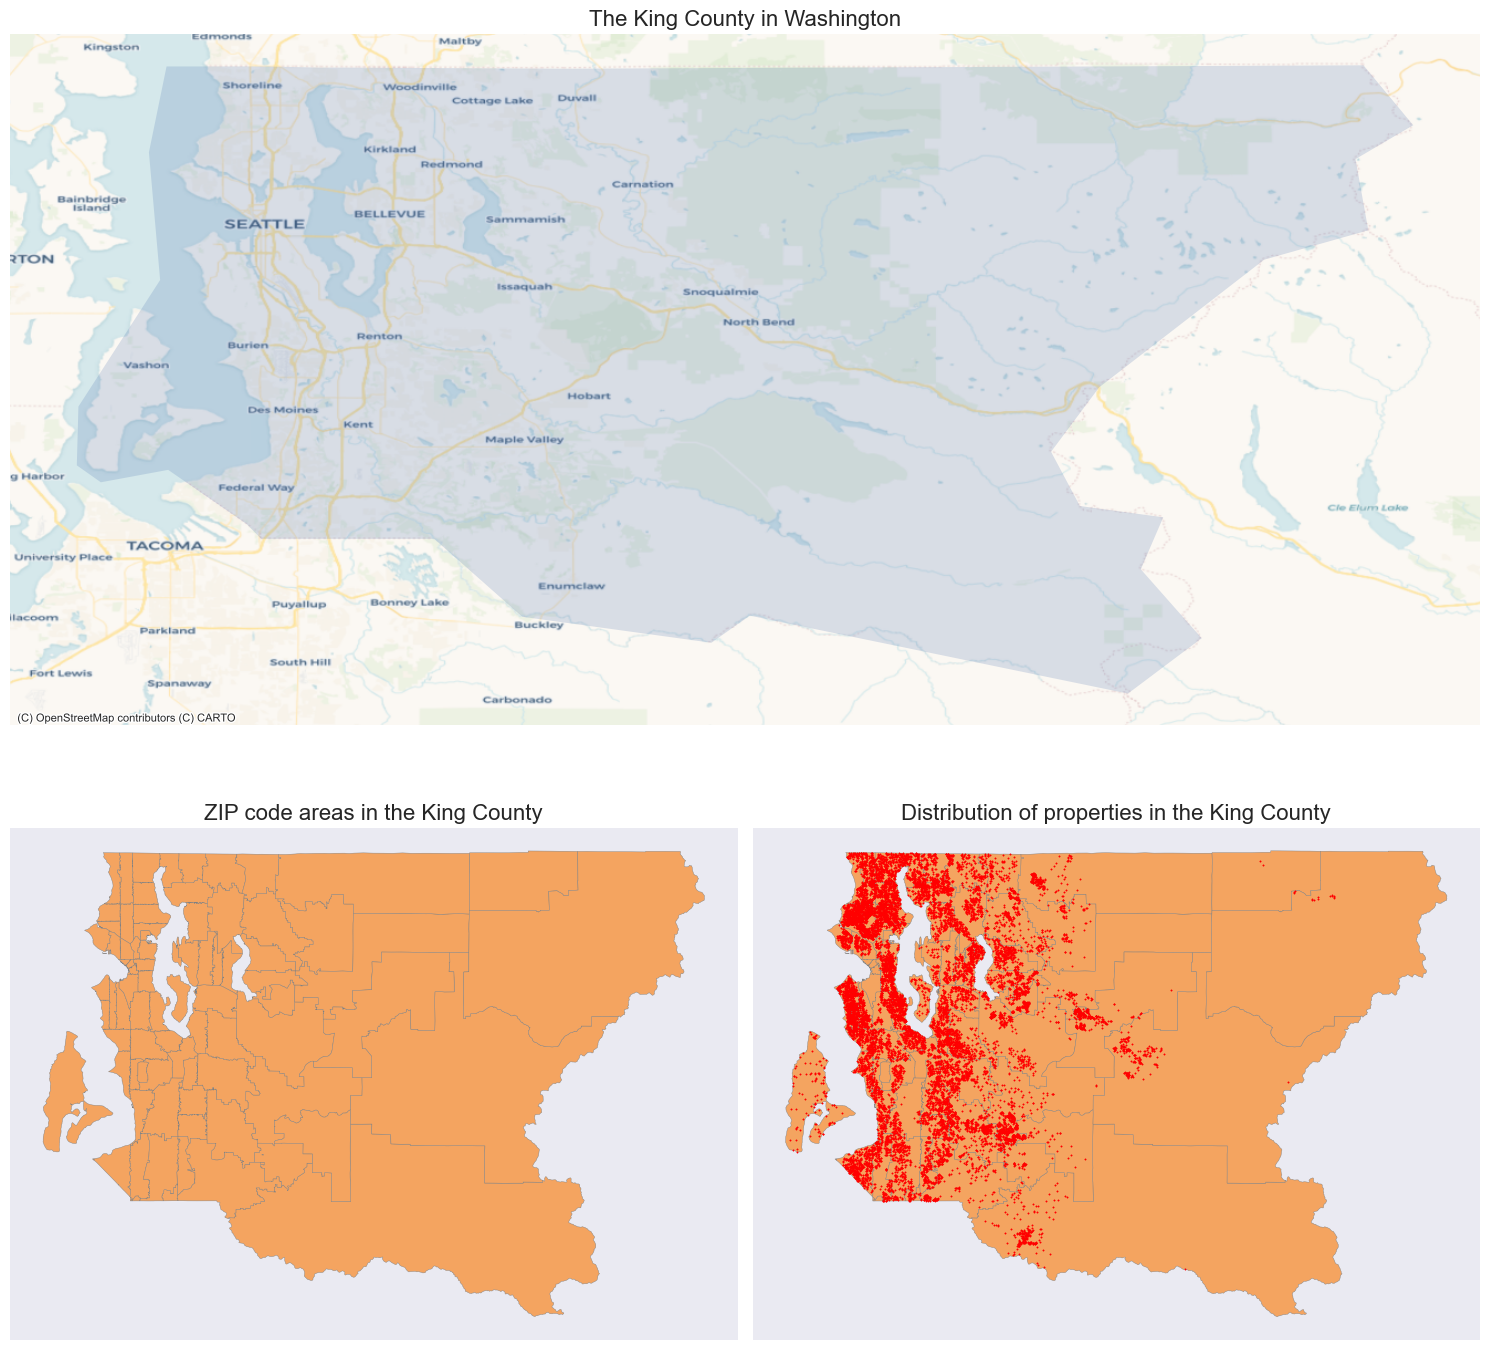

In [28]:
# Create a dashboard with 3 plots
fig = plt.figure(figsize=(15, 15))
specs = gridspec.GridSpec(nrows=2, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, :])
ax2 = fig.add_subplot(specs[1, 0])
ax3 = fig.add_subplot(specs[1, 1])


# Plot 1
ax1.set_title('The King County in Washington', fontsize=16);
# Plot region polygon with transparency alpha=0.2
gdf_kc.plot(ax=ax1, alpha=0.2)
# Add a map of the region
cx.add_basemap(ax1, crs=gdf_kc_zips.crs, zoom=10,
              source=cx.providers.CartoDB.Voyager)
# Turn off x and y values
ax1.set_xticks([]),ax1.set_yticks([])


# Plot 2
ax2.set_title('ZIP code areas in the King County', fontsize=16)
# Plot the zip regions
gdf_kc_zips.plot(ax=ax2, color='sandybrown', edgecolor='gray')
# Turn off x and y values
ax2.set_xticks([]),ax2.set_yticks([]);


# Plot 3
ax3.set_title('Distribution of properties in the King County', fontsize=16)
# Plot the zip regions
gdf_kc_zips.plot(ax=ax3, color='sandybrown', edgecolor='gray')
# Plot the properties location using red dots
data.plot(ax=ax3, markersize=1, color='red')
# Turn off x and y values
ax3.set_xticks([]),ax3.set_yticks([])

plt.tight_layout();

## Distribution of properties per ZIP code

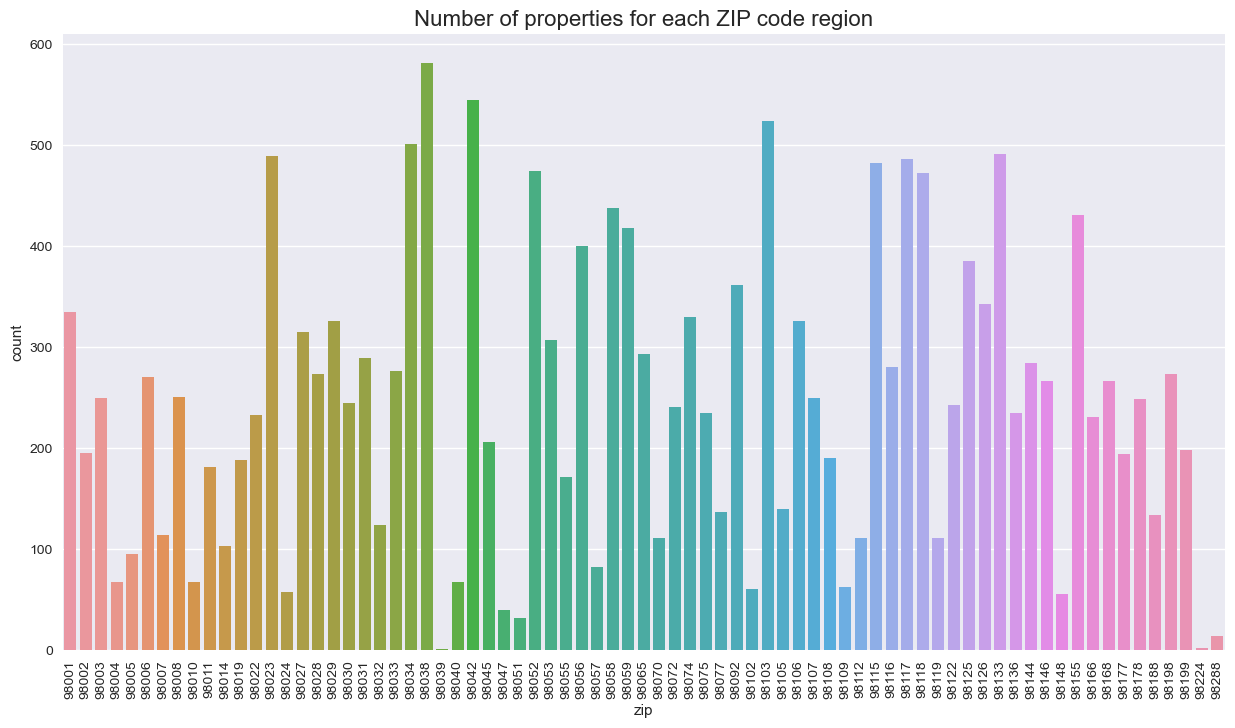

In [29]:
plt.figure(figsize=(15,8))
plt.title('Number of properties for each ZIP code region', fontsize=16)
# Count properties per zip code
df = data[['zip','id']].groupby('zip').count()
df.columns = ['count']
sns.barplot(data=df, y='count', x=df.index)
plt.tick_params(axis='x',labelrotation=90);

## Distribution of properties per attributes

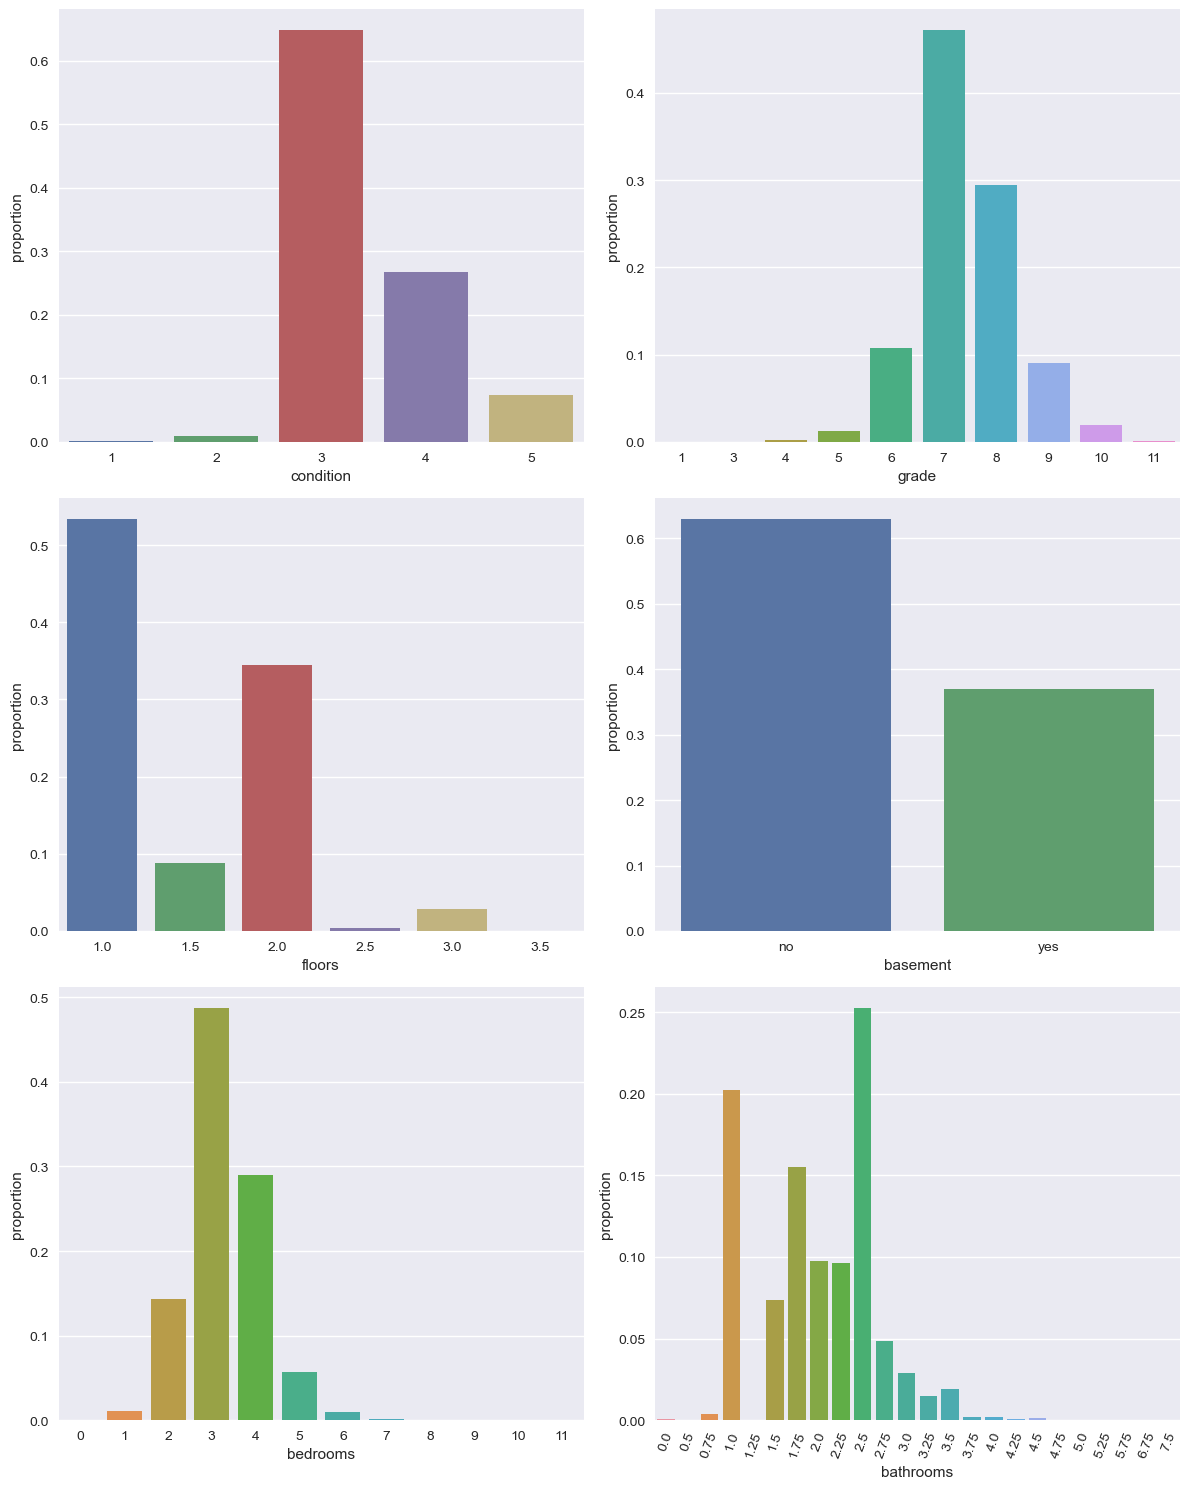

In [30]:
# Create a dashboard with 6 plots
fig = plt.figure(figsize=(12, 15))
specs = gridspec.GridSpec(nrows=3, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
ax3 = fig.add_subplot(specs[1, 0])
ax4 = fig.add_subplot(specs[1, 1])
ax5 = fig.add_subplot(specs[2, 0])
ax6 = fig.add_subplot(specs[2, 1])

# Plot 1
df = data['condition'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax1)
ax1.set(xlabel='condition')

# Plot 2
df = data['grade'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax2)
ax2.set(xlabel='grade')

# Plot 3
df = data['floors'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax3)
ax3.set(xlabel='floors')

# Plot 4
df = data['basement'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax4)
ax4.set(xlabel='basement')

# Plot 5
df = data['bedrooms'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax5)
ax5.set(xlabel='bedrooms')

# Plot 4
df = data['bathrooms'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax6)
ax6.set(xlabel='bathrooms')
ax6.tick_params(axis='x', labelrotation=70);

plt.tight_layout()
plt.show()

## Price distribution

### Overall price distribution

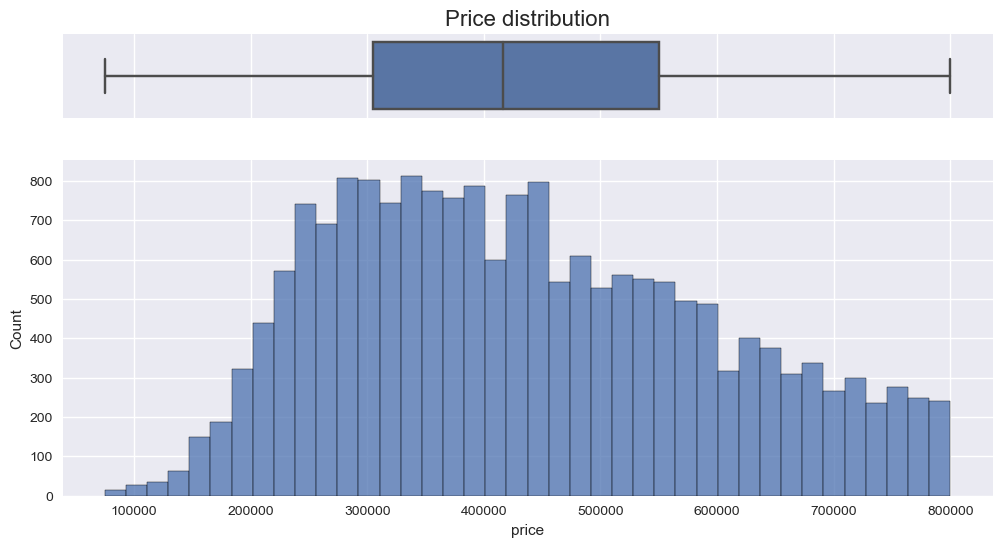

In [31]:
# Ploting price distribution: boxplot and histogram
f, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex=True, 
                                    gridspec_kw={"height_ratios": (.20, .80)},
                                    figsize=(12, 6))
 
# Plot title
ax_box.set_title('Price distribution', fontsize=16)

# Plots
sns.boxplot(data=data, x='price', ax=ax_box)
sns.histplot(data=data, x='price', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Median price per time: year built, year of renovation, and date

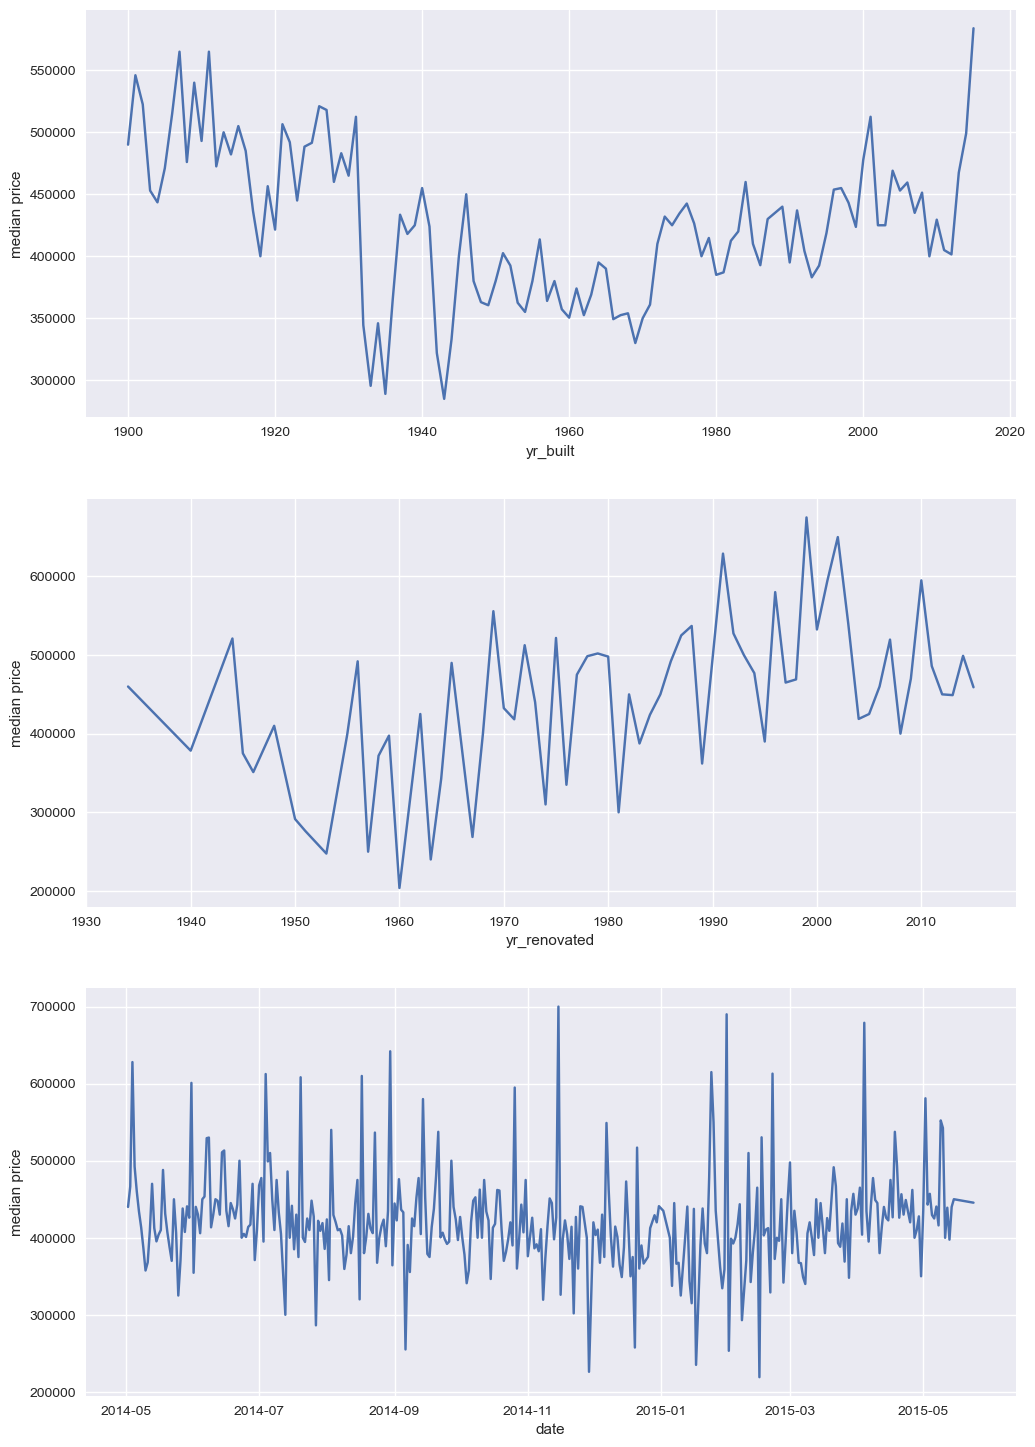

In [32]:
# Create a dashboard with 3 plots
fig = plt.figure(figsize=(12, 18))
specs = gridspec.GridSpec(nrows=3, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[1, 0])
ax3 = fig.add_subplot(specs[2, 0])

# Plot 1
df = data[['yr_built', 'price']].groupby('yr_built').median().reset_index()
df.columns = ['yr_built', 'median price']
sns.lineplot(x='yr_built', y='median price', data=df, ax=ax1)

# Plot 2
df = data[['yr_renovated', 'price']].groupby('yr_renovated').median().reset_index()
df = df.loc[df['yr_renovated'] != 0] # Exclude 0 values
df.columns = ['yr_renovated', 'median price']
sns.lineplot(x='yr_renovated', y='median price', data=df, ax= ax2)

# Plot 3
df = data[['date', 'price']].groupby('date').median().reset_index()
df.columns = ['date', 'median price']
sns.lineplot(x='date', y='median price', data=df, ax= ax3)

plt.show()

<b>Note:</b> Next, let's aggregate the data for a better visualization of price patterns.

#### Median price per time: aggregating in ten years (year built and renovation) and months (date)

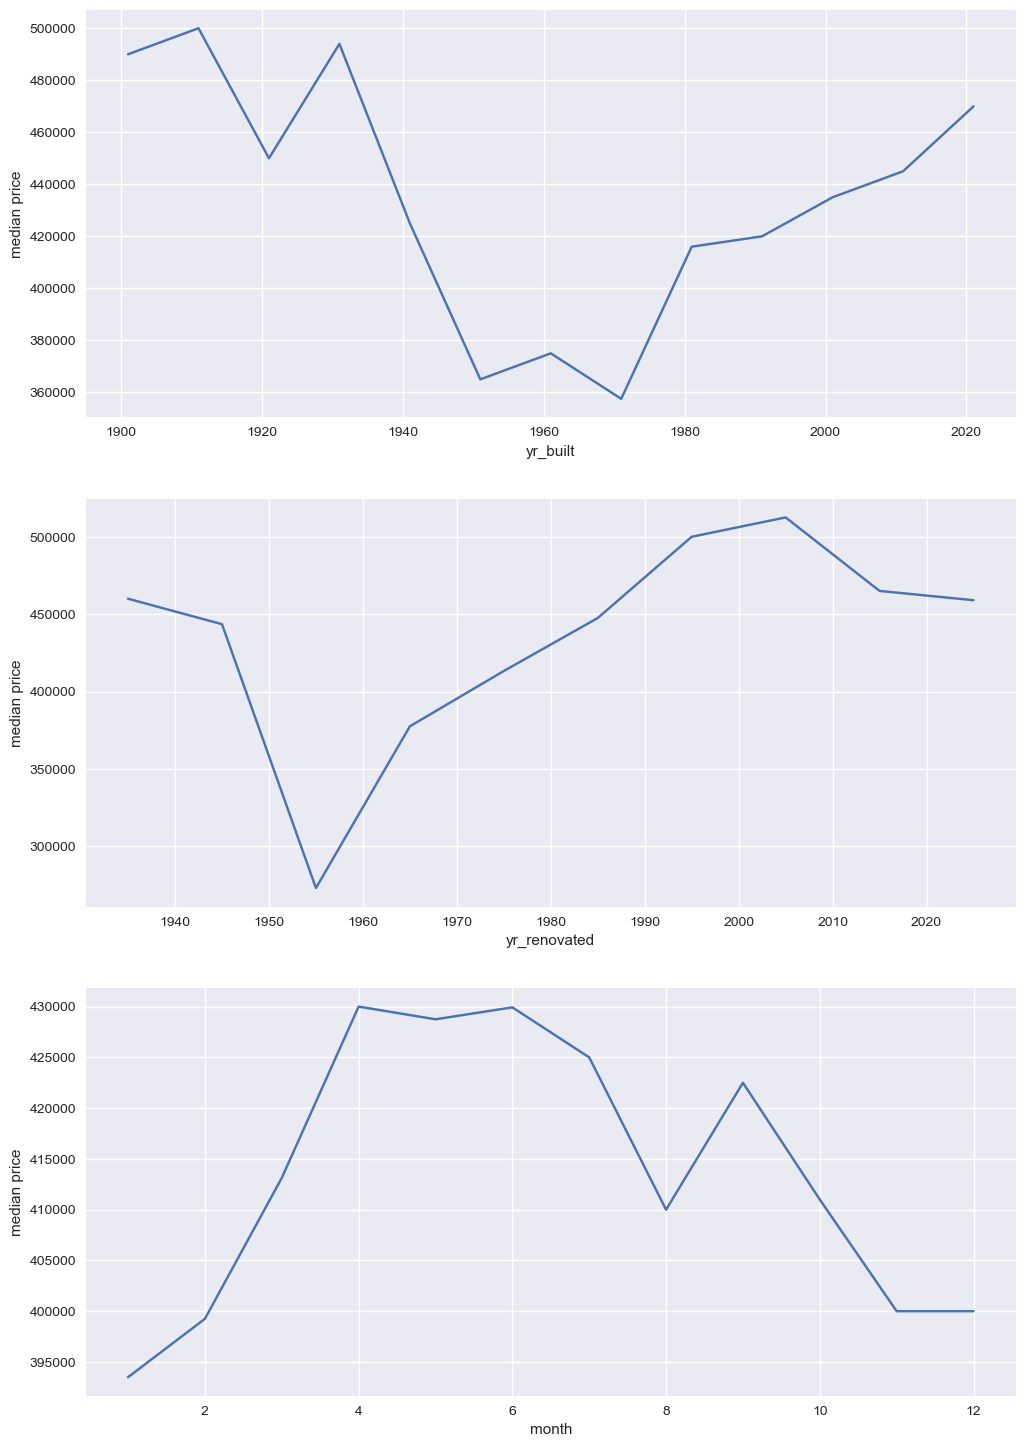

In [33]:
# Create a dashboard with 3 plots
fig = plt.figure(figsize=(12, 18))
specs = gridspec.GridSpec(nrows=3, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[1, 0])
ax3 = fig.add_subplot(specs[2, 0])

# Plot 1
df = data[['yr_built', 'price']].copy()
df['yr_built'] = pd.to_datetime(df['yr_built'], format='%Y')
df.set_index('yr_built', inplace=True)
# Resample data: each 10 years
df = df[['price']].resample('10A').median()
df.columns = ['median price']
sns.lineplot(x='yr_built', y='median price', data=df, ax=ax1)

# Plot 2
df = data[['yr_renovated', 'price']].copy()
df = df.loc[df['yr_renovated'] != 0] # Exclude 0 values
df['yr_renovated'] = pd.to_datetime(df['yr_renovated'], format='%Y')
df.set_index('yr_renovated', inplace=True) 
# Resample date: each 10 years
df = df[['price']].resample('10A').median()
df.columns = ['median price']
sns.lineplot(x='yr_renovated', y='median price', data=df, ax= ax2)

# Plot 3
df = data[['date', 'price']].copy()
df = df.sort_values('date').set_index('date')
# group data using month
df = df[['price']].groupby(by=df.index.month).median()
df = df.reset_index()
df.columns=['month', 'median price']
sns.lineplot(x='month', y='median price', data=df, ax= ax3)

plt.show()

<b>Note:</b> In `yr_built`, we observe a price drop for houses built between 1940 and 1970. In `yr_renovated`, we observe a price drop for houses renovated between 1950 and 1960. <br>
Regarding the`month` of listing, we observe lower prices for houses announced in January, February, November and December, and higher prices from April to July. 

### Median price per ZIP code

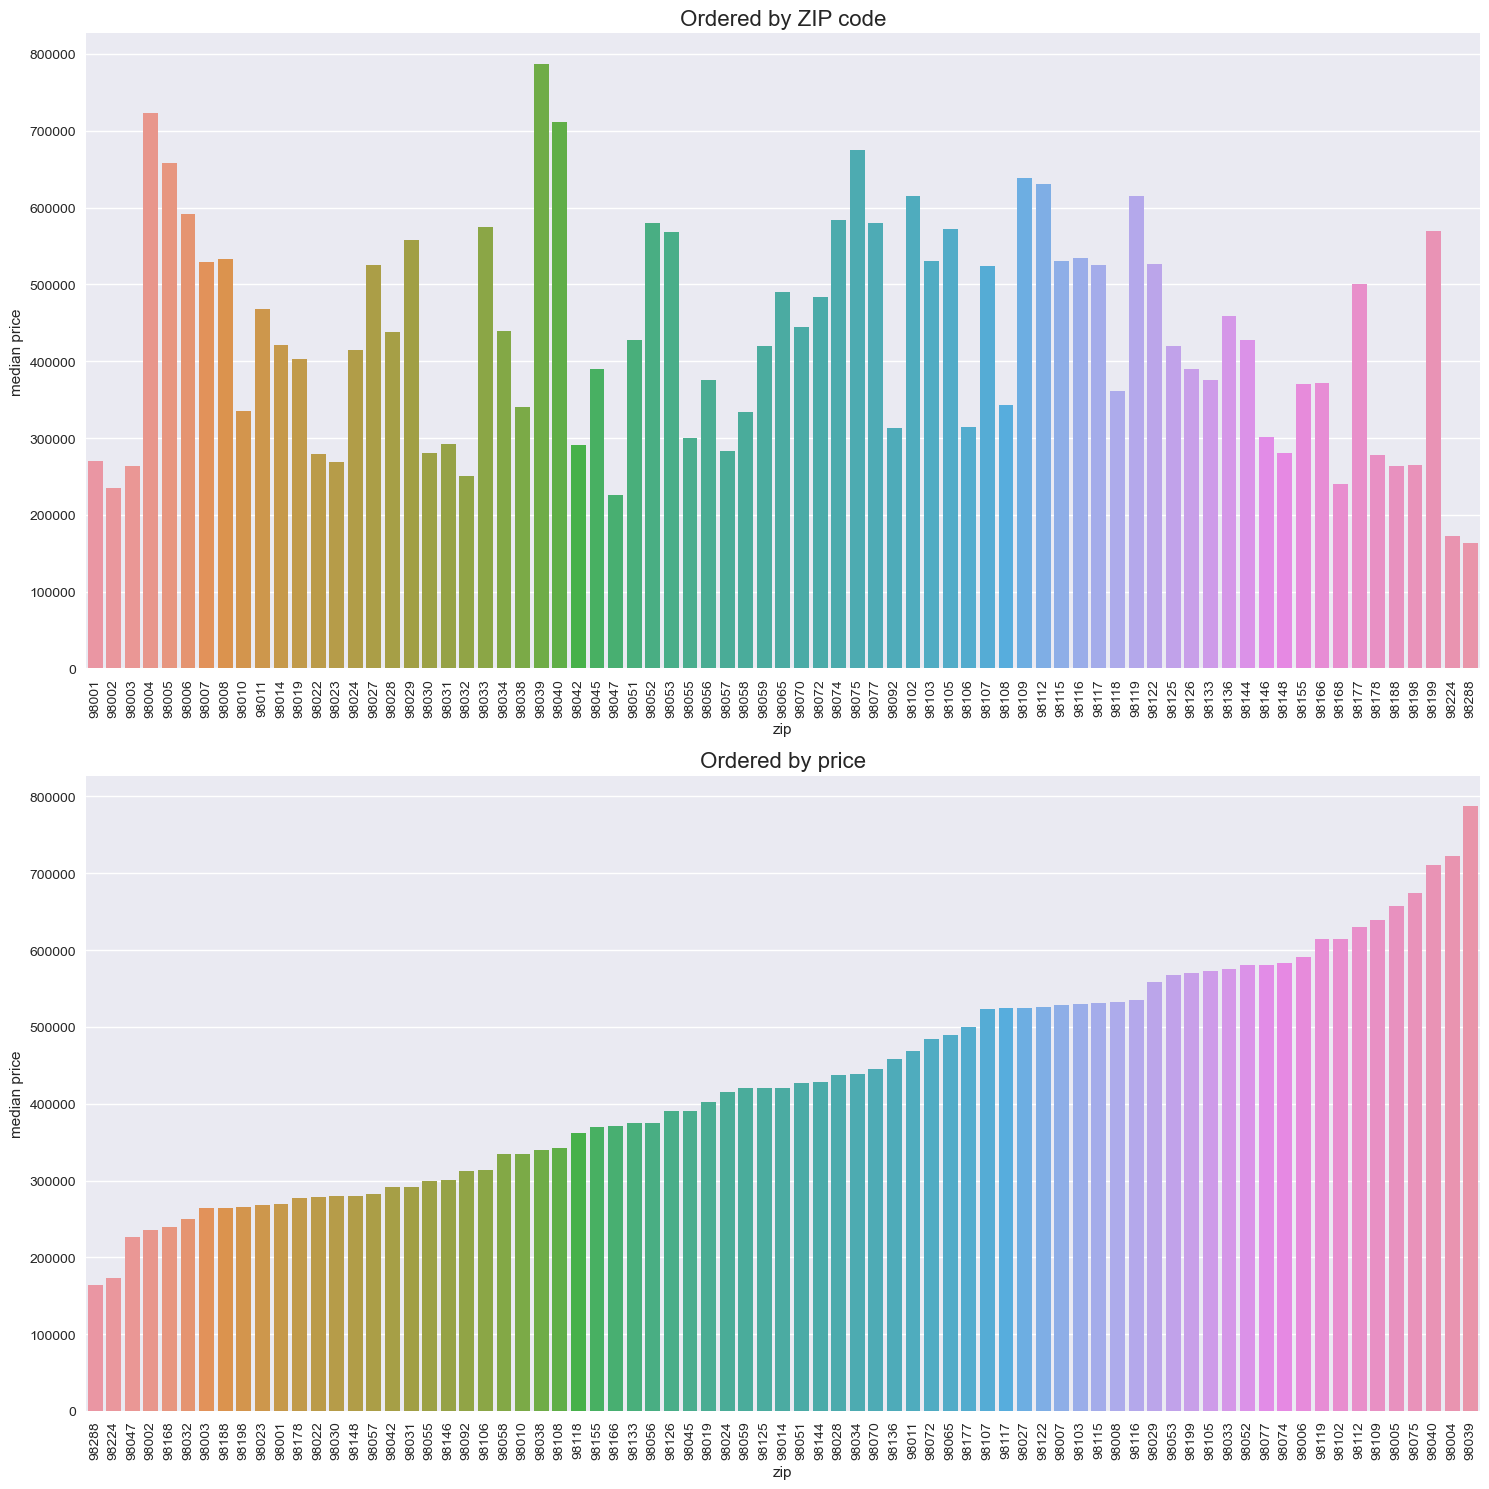

In [34]:
# Create a dashboard with 2 plots
fig = plt.figure(figsize=(15, 15))
specs = gridspec.GridSpec(nrows=2, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[1, 0])


# Plot 1
df = data[['zip','price']].groupby('zip').median().sort_values('price').reset_index()
df.columns=['zip', 'median price']
sns.barplot(data=df, y='median price', x='zip', ax=ax1)
ax1.set_title('Ordered by ZIP code', fontsize=16)
ax1.tick_params(axis='x', labelrotation=90);

# Plot 2
df = data[['zip','price']].groupby('zip').median().sort_values('price').reset_index()
df['zip'] = df['zip'].astype(str)
df.columns=['zip', 'median price']
sns.barplot(data=df, y='median price',x='zip')
ax2.set_title('Ordered by price', fontsize=16)
ax2.tick_params(axis='x', labelrotation=90);


plt.tight_layout()
plt.show()

#### Visualization of median price per ZIP region using a map

In [35]:
# Get the median prices grouped by zip
medians_zip = data[['zip','price']].groupby('zip').median().reset_index()
# Rename columns
medians_zip.rename(columns={'price':'median price', 'zip':'ZIP'}, inplace=True)
# Get the geometry information for each ZIP 
medians_zip = medians_zip.merge(gdf_kc_zips[['ZIP', 'geometry']], on='ZIP')
# Transform into a geopandas DF
medians_zip = gpd.GeoDataFrame(medians_zip)

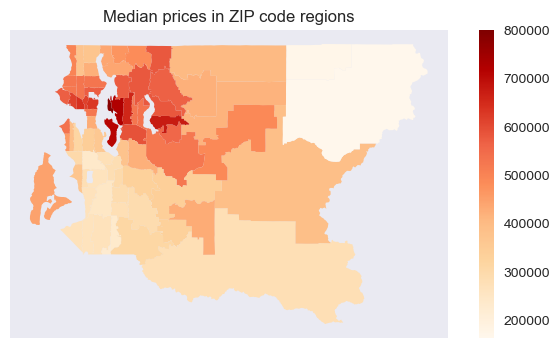

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot median price per zip code region with colorbar
medians_zip.plot(column='median price',
                 cmap='OrRd',
                 legend=True,
                 vmax=800000,
                 ax=ax)
ax.set_title('Median prices in ZIP code regions')
plt.xticks([]),plt.yticks([]);

<b>Note:</b> Based on the above visualizations, we observe that region is an important variable influencing prices. As shown below, the localization regarding waterfront is also relevant for prices. 

#### Region related to waterfront 

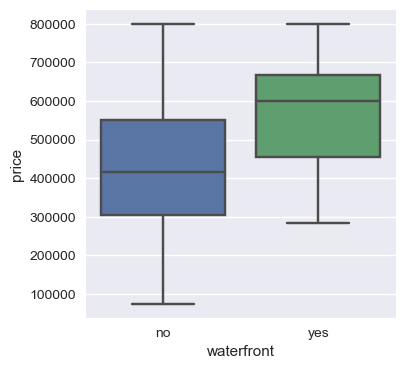

In [37]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=data, y='price', x='waterfront');

### Price distribution per area: square footage built and square footage of the lot

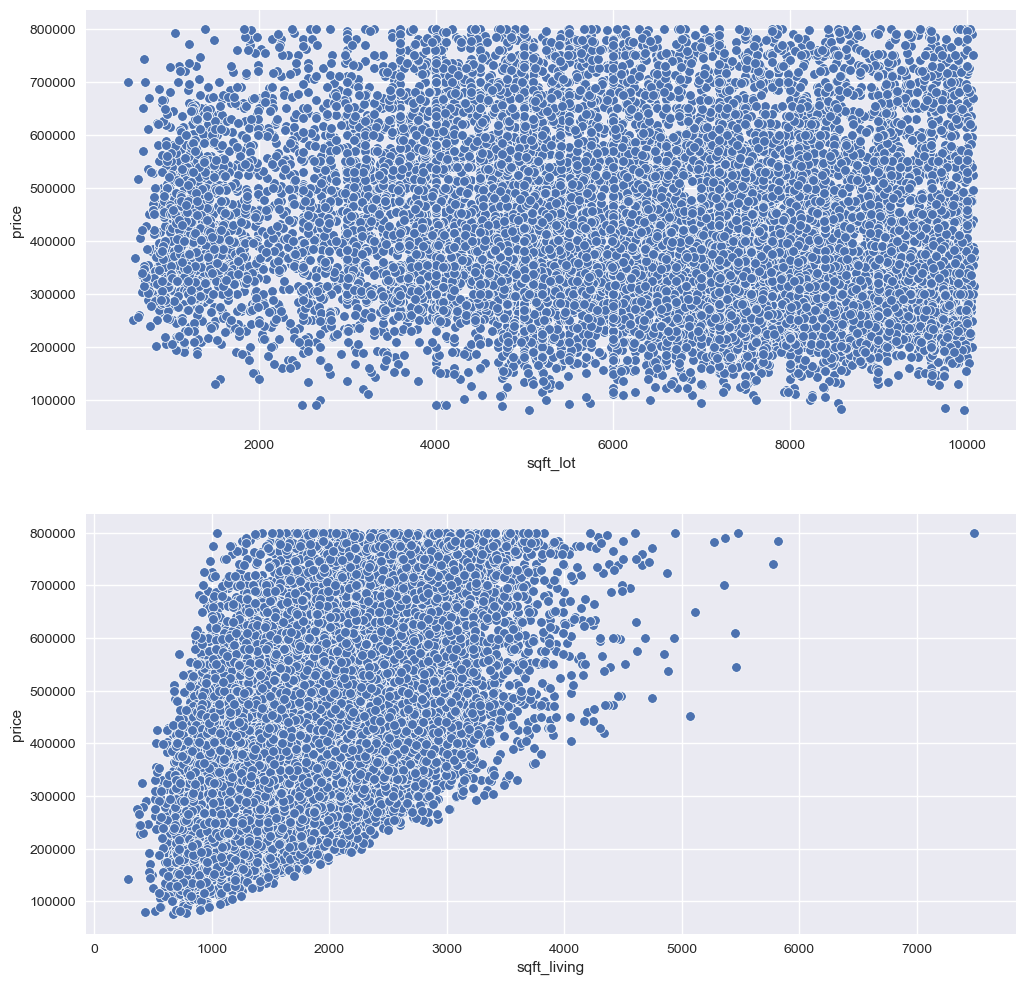

In [38]:
# Create dashboard with 2 plots
fig = plt.figure(figsize=(12, 12))
specs = gridspec.GridSpec(nrows=2, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[1, 0])


# Plot 1
df = data.loc[data['sqft_lot']<data['sqft_lot'].quantile(0.75)]
sns.scatterplot(data=df, x='sqft_lot', y='price', ax=ax1);

# Plot 2
sns.scatterplot(data=data, x='sqft_living', y='price', ax=ax2)

plt.plot();

<b>Note:</b> We can observe that property prices are related to the square footage of built area (`sqft_living`) and not to the square footage of the lot (`sqft_lot`). 

### Price distribution per attributes: floors, basement, bedrooms, and bathrooms

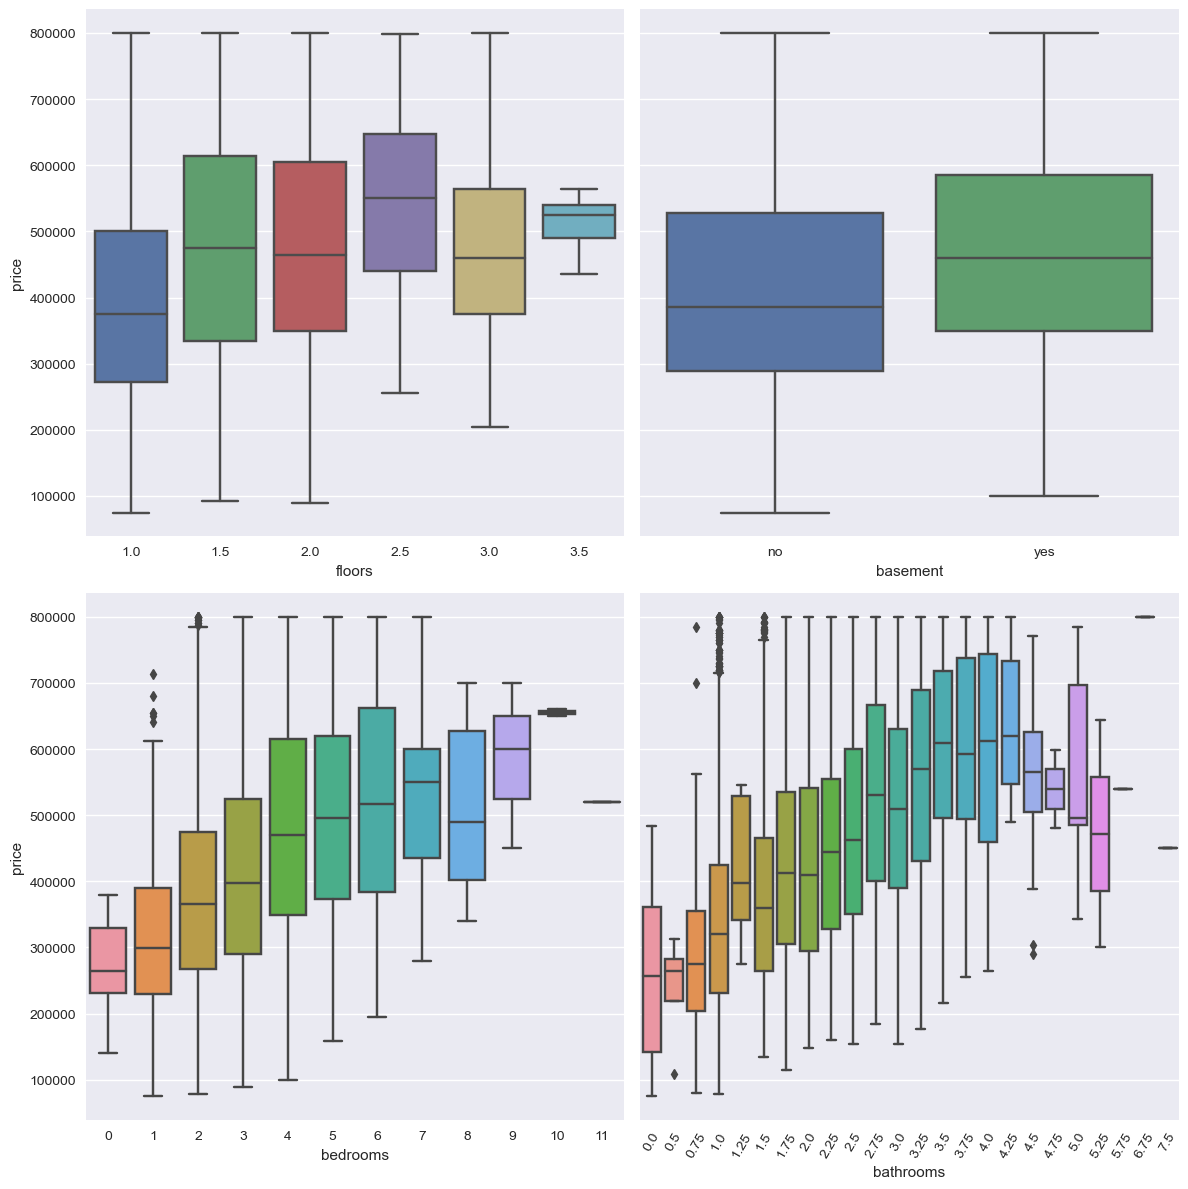

In [39]:
# Create a dashboard with 4 plots
fig = plt.figure(figsize=(12, 12))
specs = gridspec.GridSpec(nrows=2, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
ax3 = fig.add_subplot(specs[1, 0])
ax4 = fig.add_subplot(specs[1, 1])

# Plot 1
sns.boxplot(data=data, y='price', x='floors', ax=ax1)


# Plot 2
sns.boxplot(data=data, y='price', x='basement', ax=ax2)
ax2.axes.yaxis.set_ticklabels([])
ax2.set(ylabel='')

# Plot 3
sns.boxplot(data=data, y='price', x='bedrooms', ax=ax3)
#ax3.axes.yaxis.set_ticklabels([])
#ax3.set(ylabel='')

# Plot 4
sns.boxplot(data=data, y='price', x='bathrooms', ax=ax4)
ax4.axes.yaxis.set_ticklabels([])
ax4.set(ylabel='')
ax4.tick_params(axis='x', labelrotation=60);

plt.tight_layout()
plt.show()

<b>Note:</b> We can observe that prices vary according the attributes 'floors', 'basement', 'bedrooms' and 'bathrooms'.

### Price distribution per condition and grade

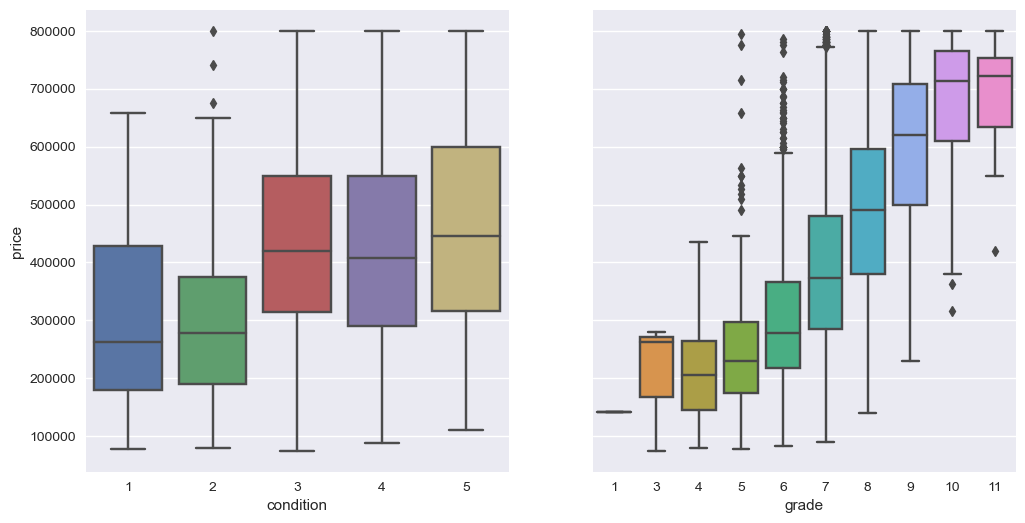

In [40]:
# Create dashboard with 2 plots
fig = plt.figure(figsize=(12, 6))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])

# Plot 1
sns.boxplot(data=data, y='price', x='condition', ax=ax1)

# Plot 2
sns.boxplot(data=data, y='price', x='grade', ax=ax2)
ax2.axes.yaxis.set_ticklabels([])
ax2.set(ylabel='')

plt.show()

<b>Note:</b> We can observe that median prices are lower for conditions 1 and 2 than the others. In the King County grading system, grades between 1 and 6 refer to houses with lower quality materials and structure. In the plot, we can observe increasing prices following increasing grades.

### Ranking of correlations between attributes and price

In [41]:
# Drop columns
cols_to_drop = ['id','lat', 'long', 'zipcode', 'zip']

# Spearman rank correlation
correlations = data.drop(cols_to_drop, axis=1).corr(method='spearman')
correlations = correlations['price'].sort_values(ascending=False)
display(correlations.drop('price').to_frame())

,price
grade,0.54
sqft_living,0.52
sqft_above,0.41
bathrooms,0.39
floors,0.26
bedrooms,0.25
sqft_basement,0.20
yr_built,0.09
yr_renovated,0.04
condition,0.01


<b>Note:</b> The attributes `grade` and `sqft_living` have the strongest correlations with price. 

# Insights

Here, we verify some hypotheses and their possible business implications. 

### Hypothesis 1: The prices are 15% higher in summer months than winter months.

<b>False.</b> The prices are up to 9.3% higher during the spring and beginning of the summer than the winter.<br> 
<b>Business implications:</b> The best months for selling properties are april, may, june, and july. The best months for buying properties are november, december, january, and february.

In [42]:
# Sort DF by date and set date as index
df = data.sort_values('date').set_index('date')
# Group the median prices by month
df = df[['price']].groupby(by=df.index.month).median()
df = df.reset_index()
df.columns=['month', 'median price'] # Rename columns
# Create columns with percent changes
df['MoM growth'] = df['median price'].pct_change() * 100
df['Growth from january'] = df['median price'].div(df['median price'][0]).subtract(1).mul(100)
display(df)

,month,median price,MoM growth,Growth from january
0,1,393500.00,NaN,0.00
1,2,399250.00,1.46,1.46
2,3,413126.00,3.48,4.99
3,4,430000.00,4.08,9.28
4,5,428750.00,-0.29,8.96
5,6,429925.00,0.27,9.26
6,7,425000.00,-1.15,8.01
7,8,410000.00,-3.53,4.19
8,9,422500.00,3.05,7.37
9,10,411000.00,-2.72,4.45


### Hypothesis 2: Waterfront properties are 30% more expensive than non waterfront properties.

<b>False.</b> Waterfront properties are 44.2% more expensive.<br>
<b>Business implications:</b> It is less likely to find bargains in the case of waterfront properties.

In [43]:
# Create empty DF
df = pd.DataFrame()
# Create column with median price group by waterfront
df['median price'] = data[['waterfront', 'price']].groupby('waterfront').median()
# Create column with percent increase 
df['percent increase'] = df['median price'].pct_change() * 100
display(df.reset_index())

,waterfront,median price,percent increase
0,no,416000.00,NaN
1,yes,600000.00,44.23


### Hypothesis 3: The least expensive properties have one score below in overall condition than the most expensive properties.

<b>False.</b> The properties with prices in the 1st quartile have the same median condition as those with prices in the 4th quartile. <br>
<b>Business implications:</b> The company may find properties with lower prices and satisfactory conditions.

In [44]:
# Get the 1st and 3rd quartiles
q_25 = data['price'].quantile(0.25) # Least expensive
q_75 = data['price'].quantile(0.75) # Most expensive

# DF with condition and price
df = data[['condition', 'price']].copy()
# Label pricing categories
df['pricing'] = data['price'].apply(lambda x: 'most expensive' if x > q_75 else
                                              'least expensive' if x < q_25 else np.NaN)
df.dropna(inplace=True) # Drop NaN
# Group by pricing, get median condition and price
df = df.groupby('pricing').median()  
df.columns=['median condition', 'median price']
display(df.reset_index())

,pricing,median condition,median price
0,least expensive,3.00,250000.00
1,most expensive,3.00,650000.00


### Hypothesis 4: The least expensive properties have one score below in overall quality (grade) than the most expensive properties.

<b>True.</b> The properties with prices in the 1st quartile have one grade bellow those with prices in the 4th quartile. <br>
<b>Business implications:</b> The company should consider that properties with lower prices are likely to have lower overall quality.

In [45]:
# Get the 1st and 3rd quartiles
q_25 = data['price'].quantile(0.25) # Least expensive
q_75 = data['price'].quantile(0.75) # Most expensive

# DF with grade and price
df = data[['grade', 'price']].copy()
df['pricing'] = data['price'].apply(lambda x: 'most expensive' if x > q_75 else
                                              'least expensive' if x < q_25 else np.NaN)
df.dropna(inplace=True) # Drop NaN
# Group by pricing, get median grade and price
df = df.groupby('pricing').median()
df.columns=['median grade', 'median price']
display(df.reset_index())

,pricing,median grade,median price
0,least expensive,7.00,250000.00
1,most expensive,8.00,650000.00


### Hypothesis 5: Renovated properties are 30% more expensive than non renovated properties.

<b>False.</b> The renovated properties are 8.4% (before 1995) and 15.7% (after 1995) more expensive than non renovated properties.<br>
<b>Business implications:</b> The company should not invest in home renovation because the costs are high and profit margins will be low.

In [46]:
# Group median price per renovation category
df = data[['renovation', 'price']].groupby('renovation').median()
df = df.sort_values('price') # Sort by price
df.columns=['median price']
# Create column with percent increase
df['percent increase'] = df['median price'].pct_change() * 100
df.reset_index(inplace=True)
display(df)

,renovation,median price,percent increase
0,no,415000.00,NaN
1,before 1995,450000.00,8.43
2,after 1995,480000.00,6.67


In [47]:
# Compare "after 1995" vs. "no" 
last_vs_first = round((df.loc[2,'median price'] / df.loc[0,'median price'] - 1) * 100, 1)
print(f'Houses renovated after 1995 are {last_vs_first}% more expensive than non renovated houses.')

Houses renovated after 1995 are 15.7% more expensive than non renovated houses.


### Hypothesis 6: Newer properties are 15% more expensive than older properties.


<b>False.</b> The properties with year built in the 4th quartile ("newer") are 4.7% more expensive than older properties (in the 1st quartile). Newer properties are 15.4% more expensive than intermediate-aged properties, which are 9.3% less expensive than older ones.<br>
<b>Business implications:</b> The company may find price bargains among properties with intermediate age.

In [48]:
# Get the 1st and 3rd quartiles
q_25 = data['yr_built'].quantile(0.25) # Older properties
q_75 = data['yr_built'].quantile(0.75) # Newer properties

# DF with yr_built and price
df = data[['yr_built', 'price']].copy()
# Create column with age category
df['age'] = data['yr_built'].apply(lambda x: 'newer' if x > q_75 else
                                             'older' if x < q_25 else 
                                             'intermediate')
# Median prices grouped by age category
df = df.groupby('age').median().sort_values('yr_built')
df.columns=['median year', 'median price']
# Create column with percent change
df['percent increase'] = df['median price'].pct_change() * 100
df['median year'] = df['median year'].astype(int) 
display(df.reset_index())

,age,median year,median price,percent increase
0,older,1932,430000.00,NaN
1,intermediate,1974,390000.00,-9.30
2,newer,2005,450000.00,15.38


In [49]:
# Compare newer vs. older
newer_vs_older = 100 * round( df.iloc[2]['median price']/ df.iloc[0]['median price']  -1, 3)
print(f'Newer properties are {newer_vs_older}% more expensive than older properties.')

Newer properties are 4.7% more expensive than older properties.


### Hypothesis 7: Newer properties have higher scores  in overall quality (grade) than older and intermediate properties.


<b>True.</b> The properties with year built in the 4th quartile ("newer") have 7.5% higher grades than intermediate-aged and 19.3% higher than "older" ones (in the 1st quartile). <br>
<b>Business implications:</b> Older properties have lower quality grade than intermediate-aged and newer properties, but without relatively lower prices (see Hypothesis 6). The company may find price bargains among properties with intermediate age.

In [50]:
# Get 1st and 3rd quartiles
q_25 = data['yr_built'].quantile(0.25) # Older properties
q_75 = data['yr_built'].quantile(0.75) # Newer properties

# DF with yr_built and grade
df = data[['yr_built', 'grade']].copy()

# Create column with age category
df['age'] = data['yr_built'].apply(lambda x: 'newer' if x > q_75 else
                                             'older' if x < q_25 else 
                                             'intermediate')
# Group mean grade per age category
df = df.groupby('age').mean().sort_values('yr_built')
df.columns=['mean year', 'mean grade']
# Calcule the 
df['percent increase'] = df['mean grade'].pct_change() * 100
df['mean year'] = df['mean year'].astype(int) 
display(df.reset_index())

,age,mean year,mean grade,percent increase
0,older,1931,6.71,NaN
1,intermediate,1973,7.45,10.92
2,newer,2005,8.01,7.54


In [51]:
# Comparing newer vs. older
newer_vs_older = 100 * round( df.iloc[2]['mean grade']/ df.iloc[0]['mean grade']  -1, 3)
print(f'Newer properties grades are {newer_vs_older}% higher than older properties.')

Newer properties grades are 19.3% higher than older properties.


# Selecting properties

The business team requested the development of an algorithm to identify the best buying opportunities and to estimate the investment cost, given the following average improvement costs: 

- US\\$ 3.00 per sqft: condition ratings <= 2
- US\\$ 2.00 per sqft: condition ratings 3 or 4
- US\\$ 1.50 per sqft: condition rating 5

In addition, the business team informed that improvement costs should not exceed 2\% of the property price.

In view of the business requests, I developed the following algorithm:
- Select the properties announced during the "buying months" (1, 2, 11, 12), when prices are lower. 
- For each region (zip code), compute and log the median price and select the properties with prices below a chosen percentile (e.g. 25%, 30%, 40%). Here, I've adoted the 30% percentile.
- Estimate the improvement costs based on conditions
- Estimate the investment costs (price + improvements)
- Compute the percentage of improvement costs in relation to the property price 
- Select the properties with improvement costs below 2\% of the property price

In [52]:
# Function for selecting properties
def select_properties( dataset, percentile):
    """This function selects properties with prices below the
    informed percentile for each region (zipcode).
    dataset: the dataset of the properties
    percentile: the percentile cutoff price 
    """
    df_buy = dataset.copy() # Make a copy of the dataset
    
    # Initialize useful lists
    buying_months = [1, 2, 11, 12] 
    zipcodes = sorted(df_buy['zip'].unique())
    
    
    # Market time
    df_buy['market_time'] = df_buy['date'].apply(lambda x: 'buy' if x.month in buying_months
                                                            else 'sell')
    
    # Select properties announced during the buying months
    df_buy = df_buy.loc[df_buy['market_time'] == 'buy']
    
    
    # Select prices below the quantile cutoff
    for region in zipcodes:
        # Median price of the region
        price_mdn = dataset.loc[dataset['zip'] == region, 'price'].quantile(0.50)      
        df_buy.loc[df_buy['zip'] == region, 'price_mdn'] = price_mdn
         
        # Select prices below the percentile cutoff informed
        cutoff = df_buy.loc[df_buy['zip'] == region, 'price'].quantile(percentile)
        idx_to_drop = df_buy[(df_buy['zip'] == region) & (df_buy['price'] >= cutoff)].index
        df_buy.drop(idx_to_drop, inplace=True)
        
    # Estimating improvement costs: criteria
    df_buy['est_costs'] = df_buy['condition'].apply(lambda x: 3 if x <= 2 else
                                                              2 if x <= 4 else
                                                              1.5)
    # Computing the estimated improvement costs
    df_buy['est_costs'] = df_buy['est_costs'] * df_buy['sqft_living']
    
    # Computing the estimated investment: price + costs
    df_buy['est_investment'] = df_buy['price'] + df_buy['est_costs']
    
    # Computing the percent of estimated costs
    df_buy['est_costs %'] = ( (df_buy['est_investment'] / df_buy['price']) -1) * 100
    
    # Filter and order by 'est_costs %'
    df_buy = df_buy.loc[df_buy['est_costs %'] <= 2]
    df_buy = df_buy.sort_values('est_costs %')
        
    return df_buy

## Applying the selection algorithm

Selecting properties below the 30th percentile.

In [53]:
# DF for the properties selected 
df_selection = select_properties(data, 0.30)
p = round((df_selection.shape[0]/data.shape[0]) * 100, 1)
print(f'A total of {df_selection.shape[0]} properties were selected.')
print(f'This represents {p}% of the total number of properties')

A total of 1311 properties were selected.
This represents 7.1% of the total number of properties


## Financial implications

For estimating the impact of adopting the proposed algorithm, I've compared:
- The sum total of the median prices with the sum total of the prices of the selected properties. 
- The sum total of the estimated investment with the sum total of the prices for estimating the impact of improvement costs.
- The estimated improvement costs (in %) with the cutoff improvement costs value (2%) established by the company.

As shown in the table below:
- The budget for buying the selected properties is 27% cheaper than median prices. 
- The estimated impact of improvement costs is 0.87%, which is 56.5% below the cutoff value of 2%. 

In [54]:
# Create DF
df = pd.DataFrame()
# The sum of median prices
df.loc['median price (sum)','US $'] = df_selection['price_mdn'].sum()
# The sum of the prices of selected properties
df.loc['price (sum)', 'US $'] = df_selection['price'].sum()
# The estimated investment 
df.loc['estimated investment (sum)', 'US $'] = df_selection['est_investment'].sum()
# Create column for the percent change
df['percent_increase'] = df['US $'].pct_change() * 100
display(df)

,US $,percent_increase
median price (sum),547530600.00,NaN
price (sum),399663386.00,-27.01
estimated investment (sum),403150150.00,0.87


#### Comparing 0.87% with the cutoff value (2%)

In [55]:
max_est_costs = 2 # 2%
obs_est_costs = round(df.loc['estimated investment (sum)', 'percent_increase'], 2)
perc_decrease = round(((max_est_costs - obs_est_costs)/max_est_costs) * 100, 1)

print(f'The estimated improvement costs ({obs_est_costs}%) are {perc_decrease}%\
 below the established cutoff (2%).')

The estimated improvement costs (0.87%) are 56.5% below the established cutoff (2%).


## Exploring the portfolio

The algorithm provided a diversified portfolio of properties with buy recommendation. This section shows the distribution of properties in terms of location, attributes, prices, condition, grade, etc.  

### Location

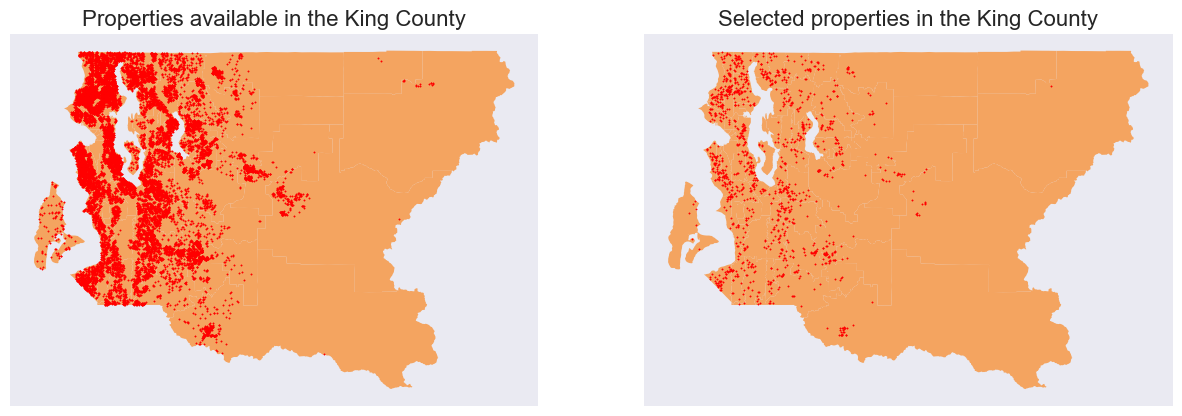

In [67]:
# Create dashboard with 2 plots
fig = plt.figure(figsize=(15, 6))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])


# Plot 1: all properties
ax1.set_title('Properties available in the King County', fontsize=16);
gdf_kc_zips.plot(ax=ax1, color='sandybrown')
data.plot(ax=ax1, markersize=1, color='red')
ax1.set_xticks([]),ax1.set_yticks([])


# Plot 2: selected properties
ax2.set_title('Selected properties in the King County', fontsize=16);
gdf_kc_zips.plot(ax=ax2, color='sandybrown')
df_selection.plot(ax=ax2, markersize=1, color='red')
ax2.set_xticks([]),ax2.set_yticks([]);


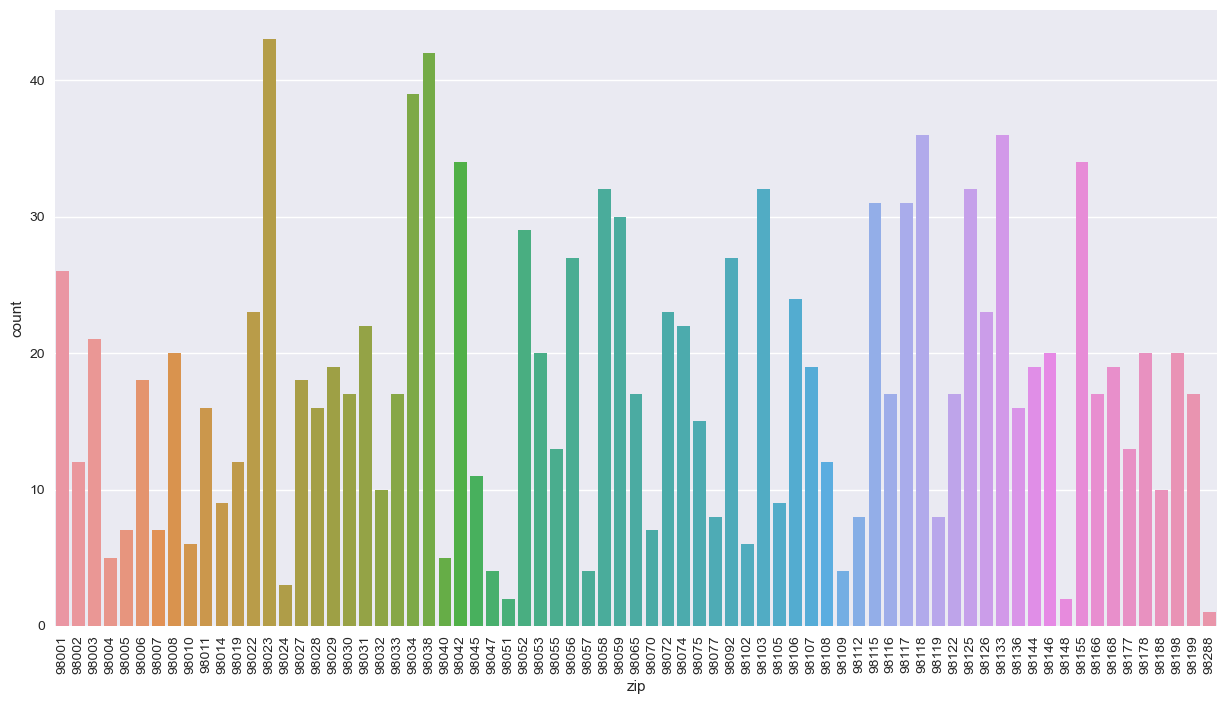

In [57]:
# Count per zip code region
plt.figure(figsize=(15,8))

df = df_selection[['zip','id']].groupby('zip').count()
df.columns = ['count']
sns.barplot(data=df, y='count', x=df.index)
plt.tick_params(axis='x',labelrotation=90);

#### Two waterfront properties were selected

In [58]:
df_selection['waterfront'].value_counts()

no     1309
yes       2
Name: waterfront, dtype: int64

In [59]:
cols = ['id', 'zip', 'waterfront', 'condition', 'grade', 
        'price', 'est_investment', 'est_costs %']
df_selection.loc[df_selection['waterfront']=='yes', cols]

,id,zip,waterfront,condition,grade,price,est_investment,est_costs %
16570,2923039243,98070,yes,3,6,340000.00,342400.00,0.71
18275,2781600195,98070,yes,3,5,285000.00,287120.00,0.74


### Distribution of attributes

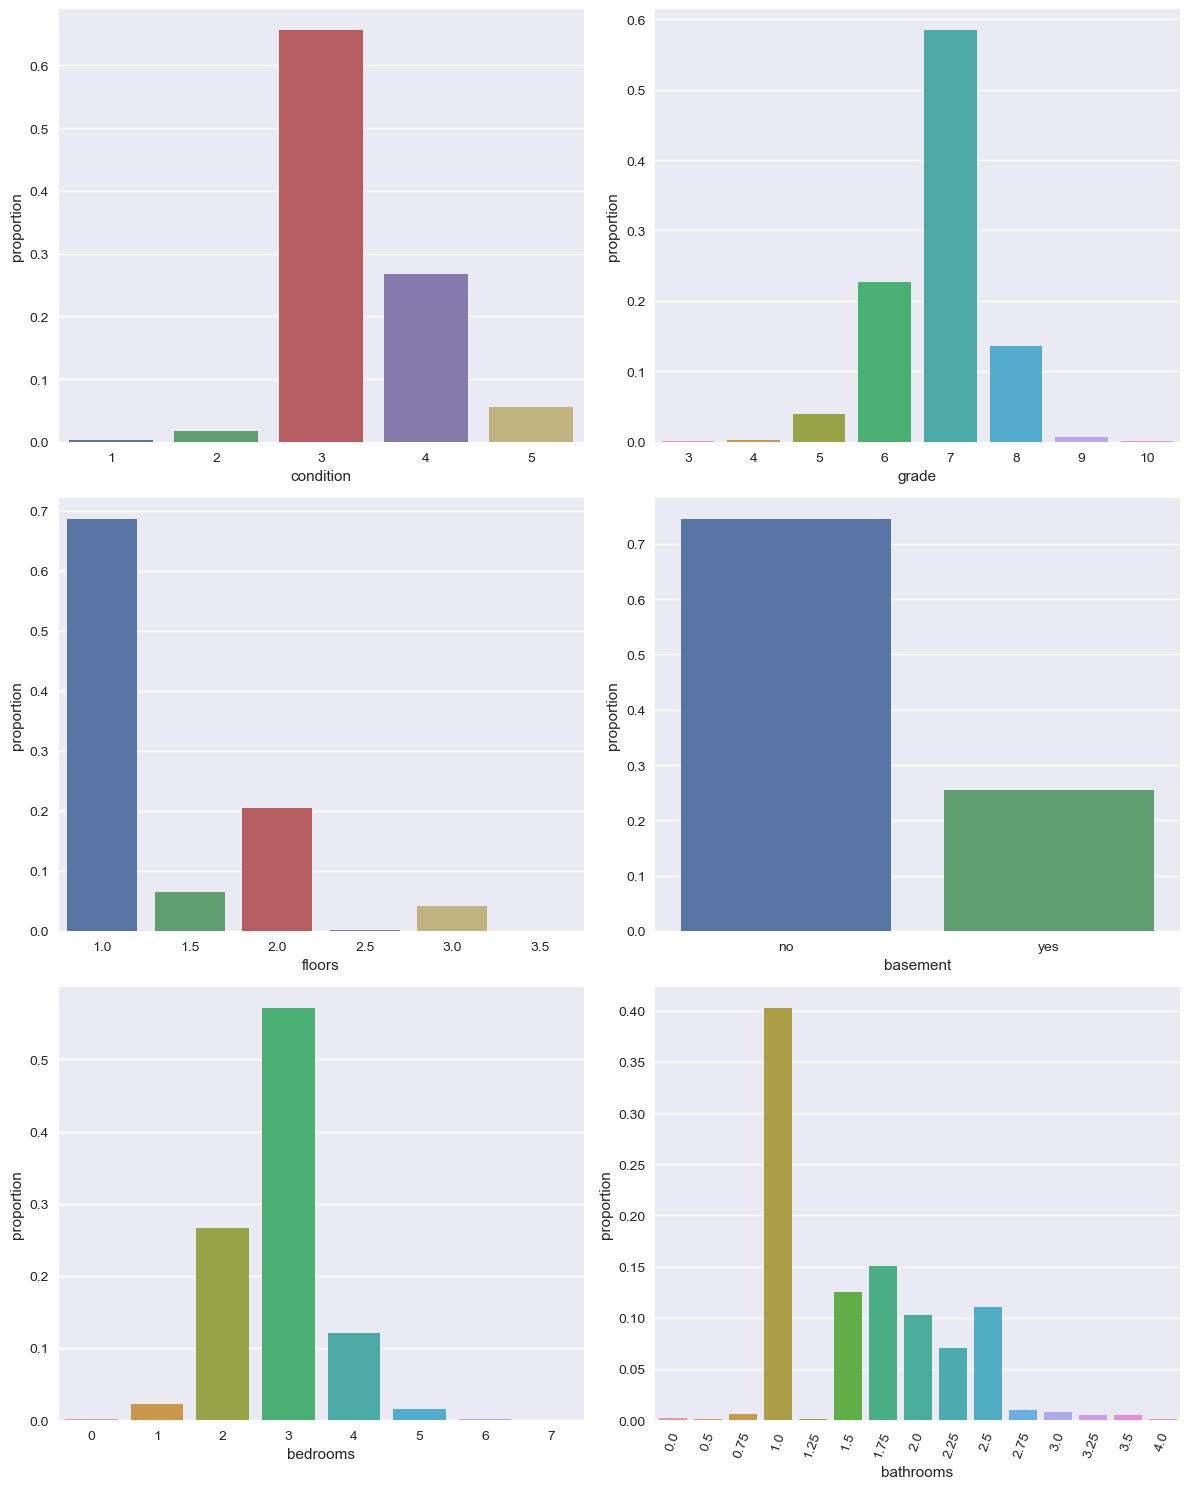

In [60]:
# Create dashboard with 6 plots
fig = plt.figure(figsize=(12, 15))
specs = gridspec.GridSpec(nrows=3, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
ax3 = fig.add_subplot(specs[1, 0])
ax4 = fig.add_subplot(specs[1, 1])
ax5 = fig.add_subplot(specs[2, 0])
ax6 = fig.add_subplot(specs[2, 1])

# Plot 1
df = df_selection['condition'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax1)
ax1.set(xlabel='condition')

# Plot 2
df = df_selection['grade'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax2)
ax2.set(xlabel='grade')

# Plot 3
df = df_selection['floors'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax3)
ax3.set(xlabel='floors')

# Plot 4
df = df_selection['basement'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax4)
ax4.set(xlabel='basement')

# Plot 5
df = df_selection['bedrooms'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax5)
ax5.set(xlabel='bedrooms')

# Plot 6
df = df_selection['bathrooms'].value_counts(normalize=True).to_frame().sort_index()
df.columns=['proportion']
sns.barplot(data=df, y='proportion', x=df.index, ax=ax6)
ax6.set(xlabel='bathrooms')
ax6.tick_params(axis='x', labelrotation=70);

plt.tight_layout()
plt.show()

### Estimated improvement costs distribution

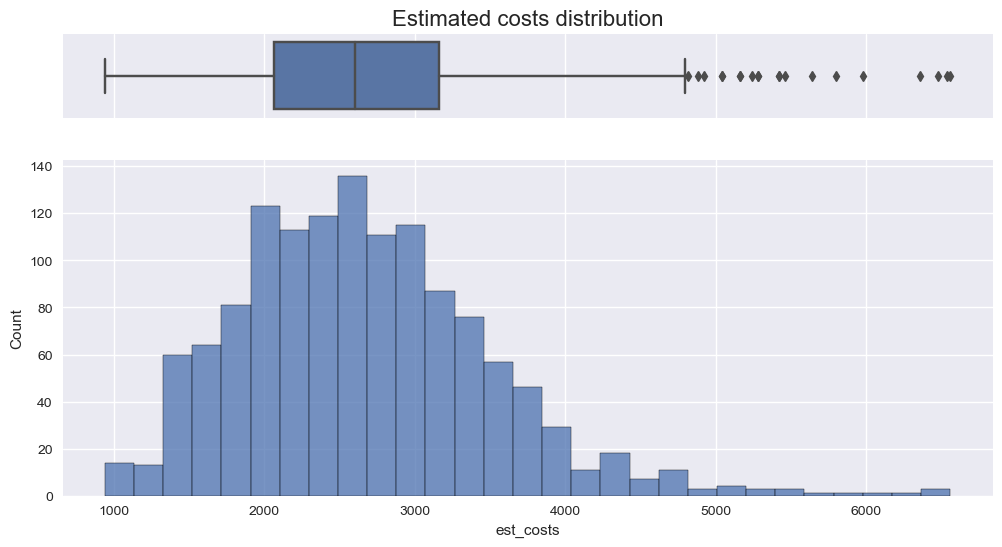

In [61]:
# Ploting costs distribution: histogram and boxplot
f, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex=True, 
                                    gridspec_kw={"height_ratios": (.20, .80)},
                                    figsize=(12, 6))
 
# assigning a graph to each ax
ax_box.set_title('Estimated costs distribution', fontsize=16)
# Plots
sns.boxplot(data=df_selection, x='est_costs', ax=ax_box)
sns.histplot(data=df_selection, x='est_costs', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Price Distribution

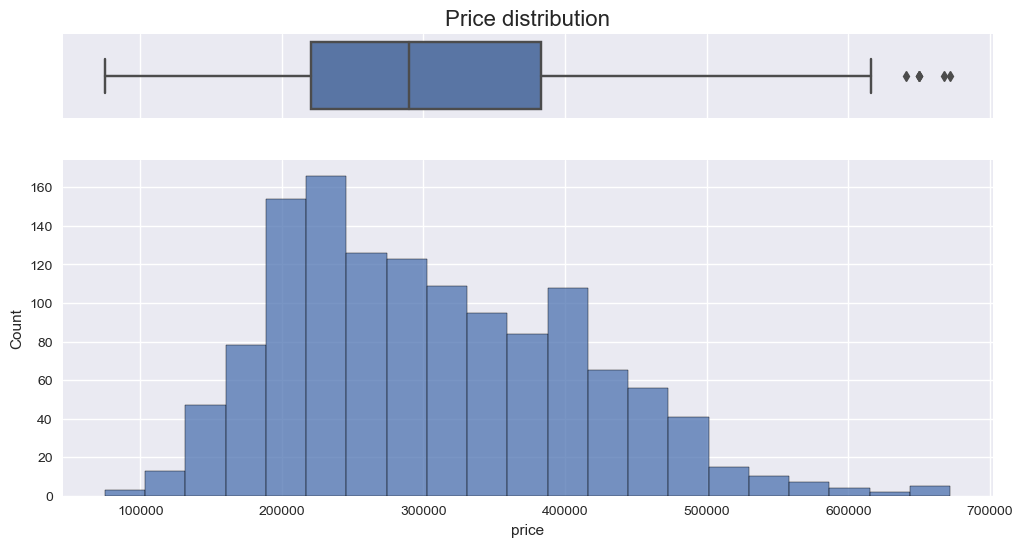

In [62]:
# Ploting price distribution: histogram and boxplot
f, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex=True, 
                                    gridspec_kw={"height_ratios": (.20, .80)},
                                    figsize=(12, 6))
 
# assigning a graph to each ax
ax_box.set_title('Price distribution', fontsize=16)
# Plots
sns.boxplot(data=df_selection, x='price', ax=ax_box)
sns.histplot(data=df_selection, x='price', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Median price per region: all data median vs. selected properties

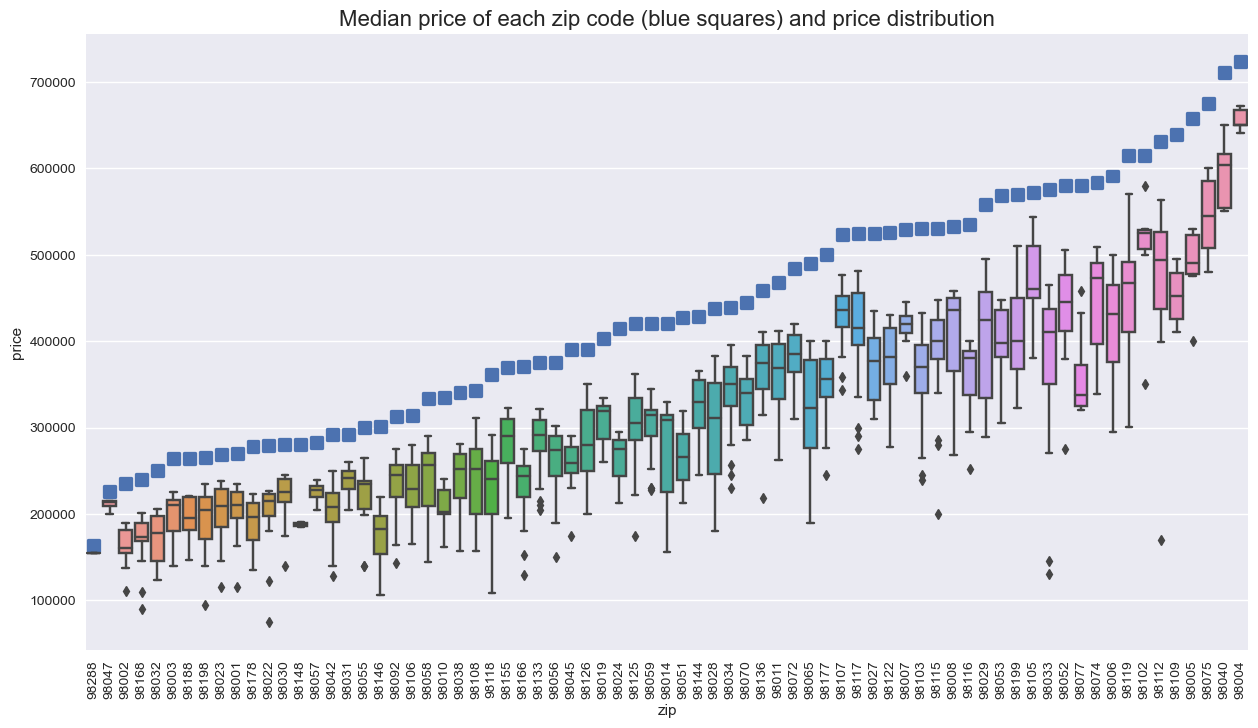

In [63]:
# Create a plot 
fig = plt.figure(figsize=(15, 8))
specs = gridspec.GridSpec(nrows=1, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])

# DF sorted by median prices
df = df_selection[['zip','price_mdn', 'price']].sort_values('price_mdn')#.reset_index()
# ZIP is converted to string so x axis become categorial
df['zip'] = df['zip'].astype(str)

# Plot the median price of zip region
sns.pointplot(data=df, x='zip', 
                        y='price_mdn', 
                        markers = 's', 
                        linestyles='', ax=ax1)

# Plot the selected prices distribution
sns.boxplot(data=df, y='price', x='zip', ax=ax1)

ax1.set_title('Median price of each zip code (blue squares) and price distribution', fontsize=16)
ax1.tick_params(axis='x', labelrotation=90)
plt.show()

### Price distribution per condition and grade

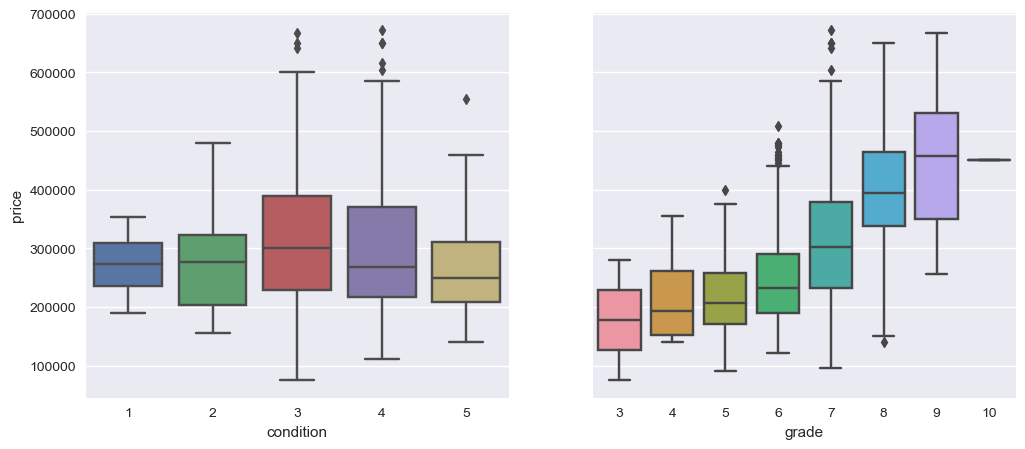

In [64]:
# Create dashboard with 2 plots
fig = plt.figure(figsize=(12, 5))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)


ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])

# Plot 1
sns.boxplot(data=df_selection, y='price', x='condition', ax=ax1)

# Plot 2
sns.boxplot(data=df_selection, y='price', x='grade', ax=ax2)
ax2.axes.yaxis.set_ticklabels([])
ax2.set(ylabel='');

### Price distribution according to house attributes

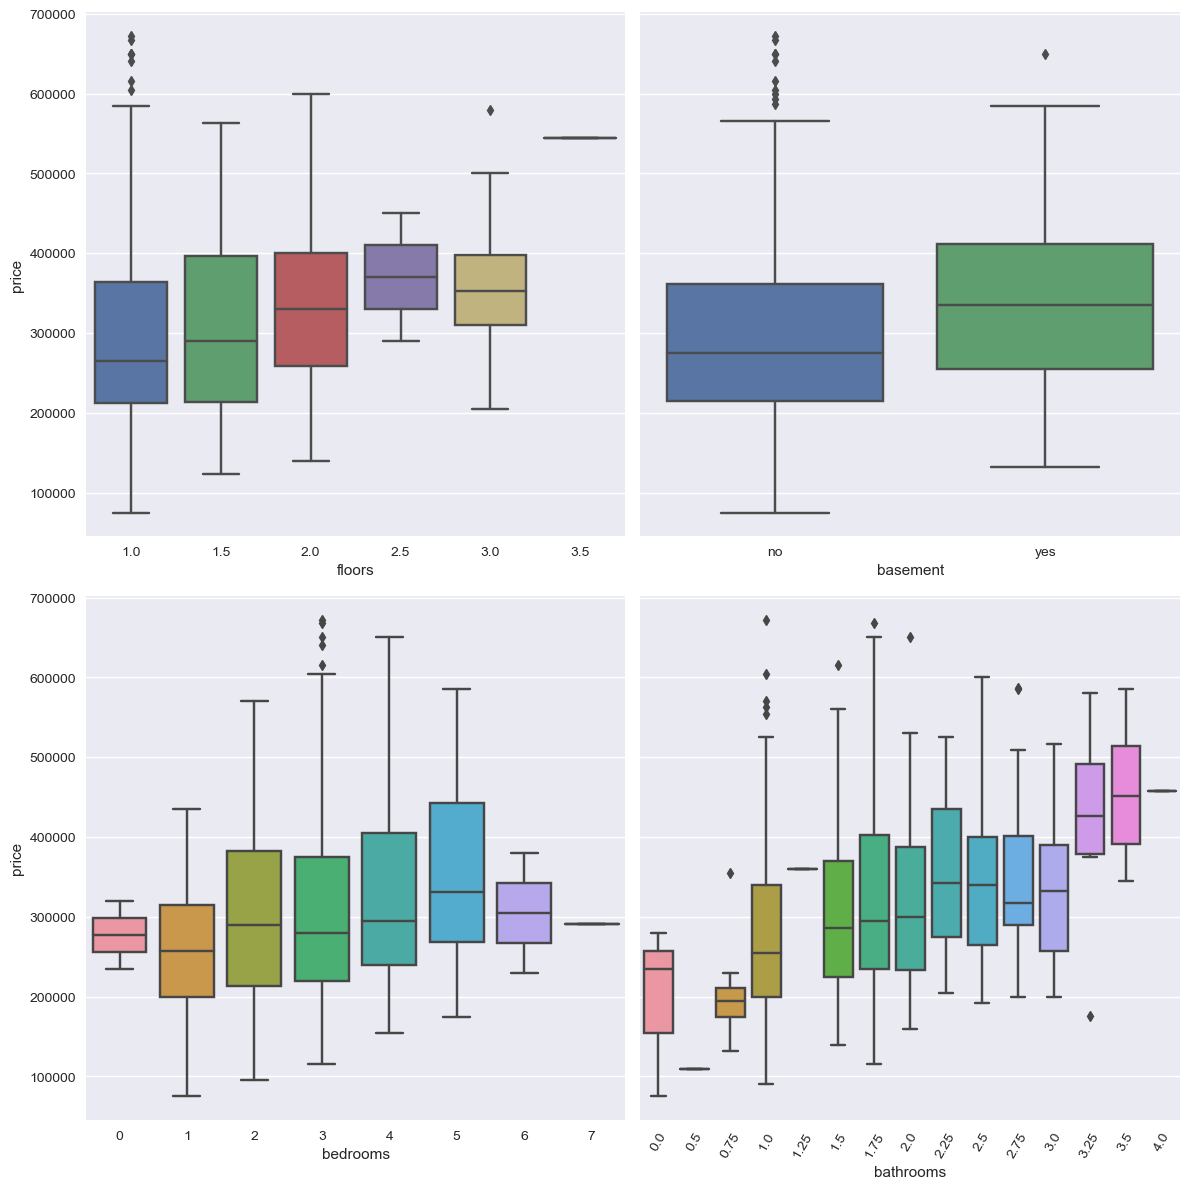

In [65]:
# Create dashboard with 4 plots
fig = plt.figure(figsize=(12, 12))
specs = gridspec.GridSpec(nrows=2, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
ax3 = fig.add_subplot(specs[1, 0])
ax4 = fig.add_subplot(specs[1, 1])

# Plot 1
sns.boxplot(data=df_selection, y='price', x='floors', ax=ax1)


# Plot 2
sns.boxplot(data=df_selection, y='price', x='basement', ax=ax2)
ax2.axes.yaxis.set_ticklabels([])
ax2.set(ylabel='')

# Plot 3
sns.boxplot(data=df_selection, y='price', x='bedrooms', ax=ax3)

# Plot 4
sns.boxplot(data=df_selection, y='price', x='bathrooms', ax=ax4)
ax4.axes.yaxis.set_ticklabels([])
ax4.set(ylabel='')
ax4.tick_params(axis='x', labelrotation=60);

plt.tight_layout()
plt.show()

# Concluding remarks

This project aimed at deriving insights from data analysis to solve the business problem of selecting properties that represent price bargains in comparison with other properties within the same region. The detailed data visualization together with the hypotheses explored helped to understand the several factors afecting prices. <br>

- The solution produced a diversified portfolio of properties with buy recommendation.
- The solution identified properties below the median market price and with satisfactory improvement costs.
- The solution produced a responsive dashboard that may be used for decision making. See the project's page for the link.